<h1 style="text-align: center;"><img class="responsive" style="float: left;" src="https://is1-ssl.mzstatic.com/image/thumb/Purple112/v4/b5/6e/20/b56e2053-ccd2-d63f-e0fb-a1bf3774eb0b/AppIcon-0-0-1x_U007emarketing-0-0-0-10-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/230x0w.webp" alt="" width="143" height="143" /></h1>
<h1 style="text-align: center;"><img class="responsive" style="font-size: 14px; float: right;" src="https://i0.wp.com/mosefparis1.fr/wp-content/uploads/2022/10/cropped-image-1.png?fit=532%2C540&amp;ssl=1" alt="" width="163" height="165" /></h1>
<h1 style="text-align: center;"><span style="color: #000080; font-family: arial, helvetica, sans-serif;"><strong style="font-size: 24pt;">LCL Challenge</strong></span></h1>
<p style="text-align: center;"><span style="font-size: 14pt;">Scoring Immobilier: Syst&egrave;me Expert BEST&nbsp;IMMO</span></p>
<p style="text-align: center;"><span style="font-size: 10pt; font-family: verdana, geneva, sans-serif;">Lucie Gabagnou,&nbsp;Ghiles Idris,&nbsp;Armand L'Huillier,&nbsp;Yanis Rehoune</span></p>

Ce projet se fait dans le cadre d'un challenge proposé par Mohamed Sneiba Hamoud. Le but est de challenger le modèle de scoring existant dans l'octroi de crédit immobilier.
Les milestones de sont projets sont les suivantes: 
- Vision globale de la base de données: étude de la période + constitution des échantillons
- Preprocessing sur l'ensemble des variables (valeurs manquantes, traitement de types, etc..)
- Sélection de variables (Lasso et tests univariés avec target) + réflexion nouvelles variables
- Discrétisation des variables quantitatives + regroupement de modalités des variables qualitatives (inclut data viz stabilité)
- Modélisation classique: régression logistique + performances
- Modélisation alternative: modèle challengeant
- Grille de score



# Exploration des données et processing

### Installation de l'environnement de travail

#### Packages

In [124]:
from scipy import stats
import scipy
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection  import train_test_split,GridSearchCV,StratifiedKFold
import warnings 
warnings.filterwarnings("ignore")
import sklearn
import json
import optbinning
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.linear_model import LogisticRegression


In [125]:
from scripts.processing import convert_modalities_to_quali,na_sup_20_fill_by_0_vs_autres,compare_na_variables_duplicates,fill_by_0,imputation_for_na,get_dummies_var,drop_columns,proxys_processing,cross_variable_for_project_type
from scripts.feature_selection import test_kruskall_wallis, test_biserial, test_chi2_independance, cramers_v_btw_X, cramers_v_with_target, selection_avec_lasso,get_feature_selection_rf
from scripts.discretisation import check_mean_defaut_rate_per_category, discretisation_variables_from_chi2
from scripts.group_cat_variables import replace_encoding_by_real_labels,encoding_categorical_variables,selection_categorical_var_post_grouping,group_modalities_with_optbinning
from scripts.pipeline_preprocessing import pipeline_processing
from scripts.firststep_dataviz import min_max_for_datetime_col,missing_rate_report,stabilite_global_temps,dataviz_stability


#### Importation des données

In [126]:
""" Importation de la base de données """
raw_data = pd.read_excel("data/Bases_recents.xlsx")

In [127]:
""" Importation des bases de données externes """

chomage_data=pd.read_excel("data/taux_chomage.xlsx")
richesse_data=pd.read_excel("data/richesse.xlsx")
inondation_data=pd.read_excel("data/Gaspar.xlsx")


dict_data_extern={ 
'chomage': chomage_data, 
'richesse': richesse_data,
'inondation': inondation_data,
}

# Etude générale
- Observations de la base, partiulièrement la période étudiée
- Choix de la date de découpage Temps/ Hors-temps
- Constitution des échantillons 
- Map


In [128]:
display(raw_data.head(10))

,region_cri,date_debloc_avec_crd,DAT_VALIDE_ACCORD_CRI,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
0,ILE DE FRANCE,201405,2010-12-01,1,0,0,40,10,2,1,...,3.140729,NaN,NaN,301510.0,1.083166,1,0,0,0,1
1,ILE DE FRANCE,201405,2011-03-14,2,0,0,10,10,2,1,...,0.999205,NaN,NaN,190962.0,0.310507,0,0,0,0,0
2,PACA,201407,2011-06-21,1,0,0,40,20,1,0,...,4.375182,NaN,NaN,105000.0,1.000000,1,0,0,0,1
3,AUVERGNE,201404,2011-06-27,1,0,0,20,20,2,1,...,2.006637,0.389825,NaN,215280.0,0.800000,0,0,0,0,0
4,ILE DE FRANCE,201404,2011-09-29,3,0,0,10,10,1,0,...,4.536824,0.287687,NaN,177700.0,0.585158,0,1,1,1,1
5,ILE DE FRANCE,201407,2011-10-26,1,0,0,40,10,2,1,...,0.797385,NaN,0.029388,50000.0,0.204082,1,0,0,0,0
6,AUVERGNE,201405,2011-12-23,2,0,0,10,10,1,0,...,3.335326,0.434783,NaN,92055.0,0.339686,0,0,0,0,1
7,ILE DE FRANCE,201404,2012-05-02,2,0,0,10,10,1,0,...,5.704616,0.350730,NaN,162650.0,0.856053,0,0,0,0,1
8,ILE DE FRANCE,201502,2012-03-20,1,0,0,10,10,2,0,...,0.973411,NaN,NaN,38000.0,0.050599,0,0,0,0,0
9,ILE DE FRANCE,201405,2012-05-03,1,0,0,10,20,2,1,...,3.599439,0.459992,NaN,156500.0,0.392231,0,0,0,0,0


#### Définition de la période d'étude
Rq: la date à considérer au cours de l'étude est la date de déblocage et non la date de validation

In [129]:
""" Colonnes de date """
date_columns=["DAT_VALIDE_ACCORD_CRI","date_debloc_avec_crd"]
raw_data["date_debloc_avec_crd"]=pd.to_datetime(raw_data["date_debloc_avec_crd"],format="%Y%m")


""" Etendu de la période pour chacune des dates """

for col in date_columns:
    min_max_for_datetime_col(raw_data,col)

Date minimale pour DAT_VALIDE_ACCORD_CRI: 2014-04-01 00:00:00
Date maximale pour DAT_VALIDE_ACCORD_CRI: 2018-04-01 00:00:00
Date minimale pour date_debloc_avec_crd: 2014-04-01 00:00:00
Date maximale pour date_debloc_avec_crd: 2018-04-01 00:00:00


#### Stabilité dans le temps?

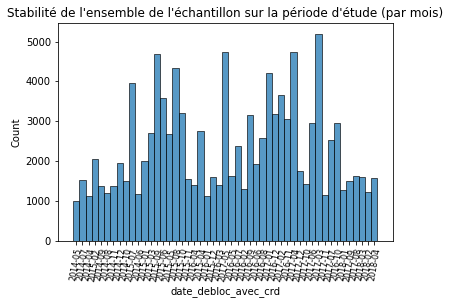

<Figure size 1008x1008 with 0 Axes>

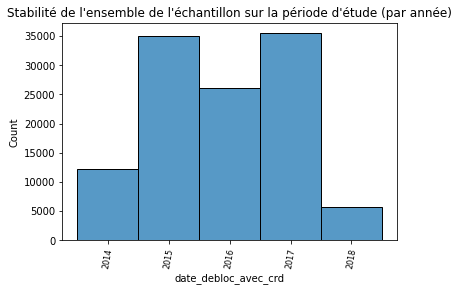

<Figure size 1008x1008 with 0 Axes>

In [130]:
stabilite_global_temps(raw_data)

Même si la base de données semble comporter des valeurs "extrêmes" (au delà de 3000 observations), il n'y a pas une distribution asymétrique entre les années (les données se comportent de la même façon au sein d'une année). On peut donc envisager un découpage hors-temps classique. Par année, le nombre d'observations peut  être différent mais cela peut être largement expliqué par le fait que les années ne sont pas complètes (pour 2014 et 2018).

In [131]:
""" Vérification des moyennes sur les potentielles Base Temps et Hors Temps """
print('base OOT :' , raw_data[raw_data["date_debloc_avec_crd"]>"2017-04-01"].mean()['defaut_36mois'] )
print('base principale :', raw_data[(raw_data["date_debloc_avec_crd"]<="2017-04-01") & (raw_data["date_debloc_avec_crd"]>= "2014-04-01"  ) ].mean()['defaut_36mois'] )



base OOT : 0.009738727530138573
base principale : 0.0063661409112362385


Les gens qui ont octroyé un prêt après 04/2017 ont eu plus de défaut sur cette période. On aura sûrement moins de facilité à trouver le défaut sachant que la base OOT a plus d'observations en moyenne comportant des défauts.
Remarque: une explication plausible du taux de défaut plus élevé pourraît être la crise de covid. En effet, les clients considérés à partir d'avril 2017 ont été observés jusqu'en avril 2021 (au max). Cela signifie, contrairement aux autres clients, qu'ils ont connu la crise du covid et la récession qui s'en suit. Peut-être, peut-on considérer base hors temps comme un choc inhabituel? 

#### Découpage de la base

- Découpage temps/hors temps (df_etude, df_hors_temps)
- Découpage base temps: échantillon d'apprentissage et de test (X_train, X_test)

##### Découpage temps/hors-temps

In [132]:
""" DECOUPAGE TEMPS/HORS TEMPS """
df_hors_temps=raw_data[raw_data["date_debloc_avec_crd"]>="2017-04-01"]
df_etude=raw_data[(raw_data["date_debloc_avec_crd"]<"2017-04-01") & (raw_data["date_debloc_avec_crd"]> "2014-04-01"  ) ]
print("Effectif base temps:", len(df_etude), " VS  Effectif base hors temps:",len(df_hors_temps) )


Effectif base temps: 85270  VS  Effectif base hors temps: 28037


Le découpage semble être plutôt approprié

##### Découpage Apprentissage/Test
Remarque: on utilise l'option stratify lors de la constitution des échantillons Train et Test de sorte à avoir un taux de défaut représentatif de l'ensemble de l'échantillon

In [133]:
""" DECOUPAGE APPRENTISSAGE/TEST """
X_train, X_test=train_test_split(df_etude,test_size=0.2 , stratify =df_etude['defaut_36mois'] )


""" Vérification que le taux de défaut sur l'échantillon d'apprentissage et validation """
print("TAUX DE DEFAUT POUR LES DEUX ECHANTILLONS:")
print( 'train :' , X_train['defaut_36mois'].mean() * 100, " vs ",'test : ' , X_test['defaut_36mois'].mean()*100)


""" ISOLATION DE LA TARGET DU RESTE"""
y=X_train["defaut_36mois"].astype(int)
drop_columns(X_train,["defaut_36mois"])


TAUX DE DEFAUT POUR LES DEUX ECHANTILLONS:
train : 0.6435440365896563  vs  test :  0.6450099683358743
Ces colonnes vont être retirées: ['defaut_36mois']


,region_cri,date_debloc_avec_crd,DAT_VALIDE_ACCORD_CRI,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2017-01-01,2016-12-19,2,0,0,10,10,1,0,...,16.056519,0.081085,NaN,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,2015-05-01,2015-03-14,1,0,0,10,10,1,0,...,4.921644,NaN,NaN,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,2016-09-01,2016-08-05,1,0,0,10,20,2,1,...,4.306012,0.303343,NaN,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,2015-05-01,2015-03-11,1,0,0,10,20,1,0,...,4.548798,NaN,NaN,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,2014-12-01,2014-12-03,1,0,0,10,20,2,1,...,2.817943,0.023290,NaN,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,2017-01-01,2016-11-26,1,0,0,40,10,1,0,...,5.398745,NaN,0.054,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,2016-07-01,2016-05-31,1,0,0,40,10,1,0,...,1.259497,1.466754,0.048,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,2015-08-01,2015-04-29,1,0,0,10,10,1,0,...,3.457938,NaN,NaN,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,2015-06-01,2015-04-16,1,0,0,10,20,1,0,...,5.239502,NaN,NaN,83554.34,1.033393,0,0,0,0,1


L'échantillon test comporte pour l'instant 20% des observations et l'échantillon d'apprentissage 80%. Par ailleurs, on remarque le taux de défaut est quasiment égal (au millième près). La stratification de l'échantillon a été efficace. 

#### Map

# Preprocessing global
- Suppression des colonnes inutiles (indiquées par le métier ou considérées comme inutiles à la suite de l'analyse)
- Traitement des types 
- Valeurs manquantes



####

### Suppression de variables a priori
- TOP_GARANTIE_CL (indiqué sur la description des variables)
- ID n'est pas utilisable


### Traitement des types 

In [134]:
""" SUPPRESSION PRE-ANALYSE"""
unused_columns_for_analysis=['TOP_GARANTIE_CL',"ID"]
drop_columns(X_train,unused_columns_for_analysis)

Ces colonnes vont être retirées: ['TOP_GARANTIE_CL', 'ID']


,region_cri,date_debloc_avec_crd,DAT_VALIDE_ACCORD_CRI,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2017-01-01,2016-12-19,2,0,0,10,10,1,0,...,16.056519,0.081085,NaN,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,2015-05-01,2015-03-14,1,0,0,10,10,1,0,...,4.921644,NaN,NaN,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,2016-09-01,2016-08-05,1,0,0,10,20,2,1,...,4.306012,0.303343,NaN,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,2015-05-01,2015-03-11,1,0,0,10,20,1,0,...,4.548798,NaN,NaN,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,2014-12-01,2014-12-03,1,0,0,10,20,2,1,...,2.817943,0.023290,NaN,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,2017-01-01,2016-11-26,1,0,0,40,10,1,0,...,5.398745,NaN,0.054,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,2016-07-01,2016-05-31,1,0,0,40,10,1,0,...,1.259497,1.466754,0.048,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,2015-08-01,2015-04-29,1,0,0,10,10,1,0,...,3.457938,NaN,NaN,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,2015-06-01,2015-04-16,1,0,0,10,20,1,0,...,5.239502,NaN,NaN,83554.34,1.033393,0,0,0,0,1


#### Variables de temps:
- On les supprime de l'analyse car ne sont pas forcément pertinente (ça aurait été le cas si on connaissait la date de tombée en défaut..)

In [135]:
""" SUPPRESSION DE VARIABLES DATETIME"""
X_train.drop(columns=date_columns,inplace=True)

#### Variables catégorielles

- On convertit les dummies en qualitatives
- On récupère la liste des variables catégorielles (présentes dans le lexique + celles qui sont géographiques..)
- On remarque que certaines variables sont en double, on regardera si certaines ont plus de NA que d'autres par la suite
- Les modalités sont souvent notées 1, 2, 3, etc... ==> Elles vont être lues comme numériques donc il faut les transformer en str (object)

In [136]:
""" TRAITEMENT DES DUMMIES"""
list_dummies=get_dummies_var(X_train)
print("Variables dummies: ",list_dummies)
convert_modalities_to_quali(X_train,list_dummies)

Variables dummies:  ['TOP_CONNU_BRP', 'TOP_SCI_BRP', 'TOP_ETR_BRP', 'TOP_PRET_RELAIS_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'TOP_ASC_DESC_BRP', 'ROL_INT_MAX_BRP', 'IND_INCIDENT_BDF_CRI', 'IND_PRIMO_ACCEDT_CRI', 'TOP_BIEN_FR_CRI', 'TOP_NAT_FR_CRI', 'top_locatif', 'top_pret_int_ext', 'top_autre_pret_int', 'top_autre_pret_ext', 'top_pers_seule']


,region_cri,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,COD_POSTAL_BIEN_CRI,CODPAY_BIEN_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2,0,0,10,10,1,0,75011,FRA,...,16.056519,0.081085,NaN,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,1,0,0,10,10,1,0,94300,FRA,...,4.921644,NaN,NaN,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,1,0,0,10,20,2,1,31270,FRA,...,4.306012,0.303343,NaN,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,1,0,0,10,20,1,0,59140,FRA,...,4.548798,NaN,NaN,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,1,0,0,10,20,2,1,33270,FRA,...,2.817943,0.023290,NaN,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,1,0,0,40,10,1,0,34560,FRA,...,5.398745,NaN,0.054,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,1,0,0,40,10,1,0,93160,FRA,...,1.259497,1.466754,0.048,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,1,0,0,10,10,1,0,94200,FRA,...,3.457938,NaN,NaN,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,1,0,0,10,20,1,0,63115,FRA,...,5.239502,NaN,NaN,83554.34,1.033393,0,0,0,0,1


In [137]:
""" CONVERSION VARIABLES CONTINUES QUI SONT DES VARIABLES CATEGORIELLES """
modalities_var=["TYP_CNT_TRA_MAX_BRP",
                "CODTYPE_PROJET_CRI",
                "COD_ETA_BIEN_CRI",
                "COD_USAGE_BIEN_CRI",
                "STA_CLP_BRP",
                "TYP_LOG_ACT_BRP",
                "QUA_INT_MAX_BRP",
                "ROL_INT_MAX_BRP",
                "CODTYP_CRT_TRAVAIL_CRI",
                "COD_SITU_LOGT_CRI",
                "COD_SIT_FAM_EMPRUNTEUR_CRI",
                "COD_TYPE_MARCHE_CRI",
                "NAT_BIEN_FIN_BRP",
                "SIT_FAM_INT_BRP",
                "COD_CPPOP_CRI", 
                "COD_CSP_BRP",
                "CSP_RGP_BRP",
                "ASU_BIEN_FIN_BRP",
                "CODTYPE_PROJET_CRI",
                "QUA_INT_1_BRP",
                "CODPAY_NAT_EMPRUNTEUR_CRI",
                "DEPARTEMENT_CRI",
                "COD_POSTAL_BIEN_CRI",
                "IRPAR_USAGE_V12_MAX",
                "IRPRO_USAGE_V12_MAX",
                "NBR_INT_BRP",
                "NBR_TOT_COEMPR_CRI",
                "NBR_ENF_ACHARGE_CRI",
                "NBR_OCCUP_CRI",

                ]  
                



convert_modalities_to_quali(X_train, modalities_var)


,region_cri,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,COD_POSTAL_BIEN_CRI,CODPAY_BIEN_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2,0,0,10,10,1,0,75011,FRA,...,16.056519,0.081085,NaN,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,1,0,0,10,10,1,0,94300,FRA,...,4.921644,NaN,NaN,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,1,0,0,10,20,2,1,31270,FRA,...,4.306012,0.303343,NaN,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,1,0,0,10,20,1,0,59140,FRA,...,4.548798,NaN,NaN,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,1,0,0,10,20,2,1,33270,FRA,...,2.817943,0.023290,NaN,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,1,0,0,40,10,1,0,34560,FRA,...,5.398745,NaN,0.054,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,1,0,0,40,10,1,0,93160,FRA,...,1.259497,1.466754,0.048,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,1,0,0,10,10,1,0,94200,FRA,...,3.457938,NaN,NaN,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,1,0,0,10,20,1,0,63115,FRA,...,5.239502,NaN,NaN,83554.34,1.033393,0,0,0,0,1


### Valeurs manquantes

Ici, on a distingué trois types de valeurs manquantes: 
- si taux > 90% on vire ces variables
- si taux entre 20 % et 90 %, on a plusieurs possibilités:
    +  si SUM = NA correspond à une valeur nulle 
    +  sinon on fait la même chose pour les variables quali et quanti que pour les na faibles

In [138]:
df_missing_rate=missing_rate_report(X_train)

,count,rate
FINANCEMENT_PR_BRP,67158,98.449044
SUM_MNT_PRE_INTERNE_BRP,66359,97.277765
TX_FINANCEMENT_AGENCE_BRP,66208,97.056409
TX_APPORT_AGENCE_BRP,66208,97.056409
TX_FINANCEMENT_BRP,66183,97.019761
...,...,...
COUT_PROJET_HF_AT_BRP,0,0.000000
MNT_COUT_TOT_CREDIT_CRI,0,0.000000
PCT_TEG_TAEG_CRI,0,0.000000
PCT_NEGOC_CRI,0,0.000000


#### NA > 90%
On enlève les variables comportant trop de na cad supérieur à 90%

In [139]:
""" TRAITEMENT NA > 90%"""
high_na=df_missing_rate.index[df_missing_rate["rate"]> 90 ].tolist()
print("TRAITEMENT VALEURS MANQUANTES > 90%")
drop_columns(X_train,high_na)

TRAITEMENT VALEURS MANQUANTES > 90%
Ces colonnes vont être retirées: ['FINANCEMENT_PR_BRP', 'SUM_MNT_PRE_INTERNE_BRP', 'TX_FINANCEMENT_AGENCE_BRP', 'TX_APPORT_AGENCE_BRP', 'TX_FINANCEMENT_BRP', 'TX_APPORT_BRP', 'mnt_pret_ext_brp', 'SUM_LOYER_BRP', 'SUM_AUTRES_CHARG_BRP']


,region_cri,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,COD_POSTAL_BIEN_CRI,CODPAY_BIEN_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2,0,0,10,10,1,0,75011,FRA,...,16.056519,0.081085,NaN,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,1,0,0,10,10,1,0,94300,FRA,...,4.921644,NaN,NaN,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,1,0,0,10,20,2,1,31270,FRA,...,4.306012,0.303343,NaN,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,1,0,0,10,20,1,0,59140,FRA,...,4.548798,NaN,NaN,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,1,0,0,10,20,2,1,33270,FRA,...,2.817943,0.023290,NaN,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,1,0,0,40,10,1,0,34560,FRA,...,5.398745,NaN,0.054,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,1,0,0,40,10,1,0,93160,FRA,...,1.259497,1.466754,0.048,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,1,0,0,10,10,1,0,94200,FRA,...,3.457938,NaN,NaN,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,1,0,0,10,20,1,0,63115,FRA,...,5.239502,NaN,NaN,83554.34,1.033393,0,0,0,0,1


#### NA < 90% 

On a fait plusieurs constats: 
- On a des variables catégorielles en double: intéressant de voir si une comporte plus de na que son doublon   / Démarche à faire pour quanti si il y a 
- SUM => Il semblerait que ces variables contiennent des na si c'est = 0 (épargne non renseignée = n'a pas d'épargne)
#

On propose une fonction qui :
- pour SUM => fill par 0
- pour variables catégorielles = imputation par mode
- pour variables quantitatives = imputation par médiane 

##### Traitement variables catégorielles en double et NaN
On remarque directement dans le lexique qu'il y a des variables en double. Si l'une des variables en doublons est plus complète qu'une autre, on a interêt à la garder 


In [140]:
""" TRAITEMENT DOUBLONS VARIABLES CATEGORIELLES POUR VALEURS MANQUANTES"""

dict_doublons={"NAT_BIEN_FIN_BRP" : "CODTYPE_PROJET_CRI",
                        "ASU_BIEN_FIN_BRP" : "COD_USAGE_BIEN_CRI",
                        "TYP_CNT_TRA_MAX_BRP" : "CODTYP_CRT_TRAVAIL_CRI",
                        "SIT_FAM_INT_BRP" : "COD_SIT_FAM_EMPRUNTEUR_CRI",
                        "TYP_LOG_ACT_BRP" : "COD_SITU_LOGT_CRI"
                        }
     
colonnes_doublons_to_drop=compare_na_variables_duplicates(X_train,dict_doublons)
drop_columns(X_train,colonnes_doublons_to_drop)


COMPARAISON NA POUR COLONNES EN DOUBLE
NAT_BIEN_FIN_BRP  VS  CODTYPE_PROJET_CRI
0  VS  0
ASU_BIEN_FIN_BRP  VS  COD_USAGE_BIEN_CRI
0  VS  0
TYP_CNT_TRA_MAX_BRP  VS  CODTYP_CRT_TRAVAIL_CRI
572  VS  572
SIT_FAM_INT_BRP  VS  COD_SIT_FAM_EMPRUNTEUR_CRI
0  VS  0
TYP_LOG_ACT_BRP  VS  COD_SITU_LOGT_CRI
0  VS  0
DONE
Ces colonnes vont être retirées: ['NAT_BIEN_FIN_BRP', 'ASU_BIEN_FIN_BRP', 'TYP_CNT_TRA_MAX_BRP', 'SIT_FAM_INT_BRP', 'TYP_LOG_ACT_BRP']


,region_cri,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,COD_POSTAL_BIEN_CRI,CODPAY_BIEN_CRI,CODTYPE_PROJET_CRI,COD_CPPOP_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2,0,0,1,0,75011,FRA,10,10,...,16.056519,0.081085,NaN,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,1,0,0,1,0,94300,FRA,10,70,...,4.921644,NaN,NaN,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,1,0,0,2,1,31270,FRA,20,130,...,4.306012,0.303343,NaN,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,1,0,0,1,0,59140,FRA,20,130,...,4.548798,NaN,NaN,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,1,0,0,2,1,33270,FRA,20,10,...,2.817943,0.023290,NaN,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,1,0,0,1,0,34560,FRA,10,70,...,5.398745,NaN,0.054,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,1,0,0,1,0,93160,FRA,10,70,...,1.259497,1.466754,0.048,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,1,0,0,1,0,94200,FRA,10,70,...,3.457938,NaN,NaN,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,1,0,0,1,0,63115,FRA,20,130,...,5.239502,NaN,NaN,83554.34,1.033393,0,0,0,0,1


#### NA > 20%
- On traite les na qui doivent avoir un traitement particulier cad qu'elles comportent bcp de na mais ne doivent pas être supprimé
- Remarque: On garde les variables de coût pour la suite

In [141]:
""" TRAITEMENT NA > 20 %"""
df_missing_rate=missing_rate_report(X_train)
missing_rate_sup_20=df_missing_rate.index[df_missing_rate["rate"]>20 ].tolist()
print("TRAITEMENT POUR VALEURS MANQUANTES >20%: ", missing_rate_sup_20)
variables_a_fill_0, variables_na_to_drop = na_sup_20_fill_by_0_vs_autres(missing_rate_sup_20)
print("Variables non supprimées: ",variables_a_fill_0)
fill_by_0(X_train, variables_a_fill_0)
drop_columns(X_train,variables_na_to_drop)


,count,rate
rentabilite_loc,56820,83.294242
SUM_RESS_IMMO_BRP,56710,83.132989
COUT_NOTAIRE_BRP,39134,57.367773
COUT_ACQ_BRP,38361,56.234608
SUM_PATR_IMMO_BRP,35343,51.810426
...,...,...
MNT_COUT_TOT_CREDIT_CRI,0,0.000000
PCT_TEG_TAEG_CRI,0,0.000000
PCT_NEGOC_CRI,0,0.000000
MNT_PRET_CRI,0,0.000000


TRAITEMENT POUR VALEURS MANQUANTES >20%:  ['rentabilite_loc', 'SUM_RESS_IMMO_BRP', 'COUT_NOTAIRE_BRP', 'COUT_ACQ_BRP', 'SUM_PATR_IMMO_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'SUM_MNT_PRE_EXTERNE_BRP', 'Epargne_nb_ans_rev_prof', 'SUM_EPARGNE_BRP', 'SUM_MTENCBIE_EPARGNE_BRP', 'SUM_TAX_FISC_BRP']
Variables non supprimées:  ['SUM_RESS_IMMO_BRP', 'COUT_NOTAIRE_BRP', 'COUT_ACQ_BRP', 'SUM_PATR_IMMO_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'SUM_MNT_PRE_EXTERNE_BRP', 'SUM_EPARGNE_BRP', 'SUM_MTENCBIE_EPARGNE_BRP', 'SUM_TAX_FISC_BRP']
IMPUTATION PAR 0
OK
Ces colonnes vont être retirées: ['rentabilite_loc', 'Epargne_nb_ans_rev_prof']


,region_cri,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,COD_POSTAL_BIEN_CRI,CODPAY_BIEN_CRI,CODTYPE_PROJET_CRI,COD_CPPOP_CRI,...,TOP_NAT_FR_CRI,CSP_RGP_BRP,Mt_credit_nb_ans_rev_prof,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2,0,0,1,0,75011,FRA,10,10,...,1,3.0,16.056519,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,1,0,0,1,0,94300,FRA,10,70,...,1,5.0,4.921644,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,1,0,0,2,1,31270,FRA,20,130,...,1,3.0,4.306012,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,1,0,0,1,0,59140,FRA,20,130,...,1,5.0,4.548798,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,1,0,0,2,1,33270,FRA,20,10,...,1,3.0,2.817943,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,1,0,0,1,0,34560,FRA,10,70,...,1,6.0,5.398745,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,1,0,0,1,0,93160,FRA,10,70,...,1,3.0,1.259497,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,1,0,0,1,0,94200,FRA,10,70,...,1,3.0,3.457938,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,1,0,0,1,0,63115,FRA,20,130,...,1,4.0,5.239502,83554.34,1.033393,0,0,0,0,1


#### NA faible (<20%)

In [142]:
""" TRAITEMENT DES VALEURS MANQUANTES POUR LES VARIABLES RESTANTES """
imputation_for_na(X_train)


IMPUTATION PAR MODE OU MEDIANE
OK


,region_cri,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,COD_POSTAL_BIEN_CRI,CODPAY_BIEN_CRI,CODTYPE_PROJET_CRI,COD_CPPOP_CRI,...,TOP_NAT_FR_CRI,CSP_RGP_BRP,Mt_credit_nb_ans_rev_prof,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,ILE DE FRANCE,2,0,0,1,0,75011,FRA,10,10,...,1,3.0,16.056519,200000.00,0.655738,0,0,0,0,1
25472,ILE DE FRANCE,1,0,0,1,0,94300,FRA,10,70,...,1,5.0,4.921644,136300.00,1.035699,0,0,0,0,1
70507,OCCITANIE,1,0,0,2,1,31270,FRA,20,130,...,1,3.0,4.306012,258352.12,1.016558,0,0,0,0,0
27802,HAUTS DE FRANCE,1,0,0,1,0,59140,FRA,20,130,...,1,5.0,4.548798,126724.96,1.017667,0,0,0,0,1
17760,AQUITAINE,1,0,0,2,1,33270,FRA,20,10,...,1,3.0,2.817943,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,OCCITANIE,1,0,0,1,0,34560,FRA,10,70,...,1,6.0,5.398745,94796.56,1.040331,1,0,0,0,1
58186,ILE DE FRANCE,1,0,0,1,0,93160,FRA,10,70,...,1,3.0,1.259497,77282.75,1.035251,1,0,0,0,1
29500,ILE DE FRANCE,1,0,0,1,0,94200,FRA,10,70,...,1,3.0,3.457938,151800.00,1.029398,0,0,0,0,1
23007,AUVERGNE,1,0,0,1,0,63115,FRA,20,130,...,1,4.0,5.239502,83554.34,1.033393,0,0,0,0,1


In [143]:
""" Vérification NA == 0 """

verif_valeurs_manquantes = X_train.isna().sum().sort_values()
print("Nombre de NaN:",verif_valeurs_manquantes)
print("TRAITEMENT DES VALEURS MANQUANTES: OK ")


Nombre de NaN: region_cri                    0
IND_PRIMO_ACCEDT_CRI          0
IND_INCIDENT_BDF_CRI          0
COD_TYPE_MARCHE_CRI           0
COD_SIT_FAM_EMPRUNTEUR_CRI    0
                             ..
MNT_PRET_CRI                  0
NBR_DUREE_TOT_PRET_CRI        0
top_exist_conso_revo_BRP      0
COUT_NOTAIRE_BRP              0
top_pers_seule                0
Length: 102, dtype: int64
TRAITEMENT DES VALEURS MANQUANTES: OK 


#### Feature engineering: Création de nouvelles variables


##### Variables proxys


In [144]:
""" Aperçu des bases"""
for df_name,df in dict_data_extern.items():
    display(df.head(10).style.set_caption(f"Aperçu de la base de l'indicateur '{df_name}'"))


,Code,MOYENNE
0,01,8.700000
1,02,6.970000
2,03,13.370000
3,04,10.060000
4,05,10.960000
5,06,9.020000
6,07,10.095000
7,08,10.325000
8,09,11.655000
9,10,11.805000


,Unnamed: 0,Loyer moyen par mètre carré de surface habitable (en €),Taux de logements sociaux
0,01,5.900000,7.160000
1,02,5.330000,7.790000
2,03,5.220000,6.090000
3,04,5.870000,4.550000
4,05,5.320000,5.690000
5,06,6.720000,5.390000
6,07,5.250000,4.190000
7,08,5.050000,9.180000
8,09,5.060000,2.370000
9,10,5.420000,10.320000


,Commune,Somme de nb_com_ddrm
0,01001,1
1,01002,0
2,01004,1
3,01005,0
4,01006,0
5,01007,1
6,01008,0
7,01009,1
8,01010,1
9,01011,0


On a deux types de jeu de données: 
- Un basé sur les codes postaux des communes
- L'autre sur les départements

On dispose des deux colonnes dans le dataframe de base, ce qui va nous permettre de réaliser facilement un merge:
- DEPARTEMENT_CRI

In [145]:
""" PREPROCESSING DES VARIABLES PROXYS """
X_proxys=X_train.copy()
proxys_processing(X_proxys,dict_data_extern)

In [146]:
proxys_var=["PRIX_LOYER","TAUX_CHOMAGE","TAUX_HLM"]

##### Croisement de variables
Nous avons fait le croisement de la variable COD_CPOP_CRI (type de projet) avec les coûts. On va combiner deux informations simultanément: 
- La nature du projet 
- Les coûts pour chaque type de projet

Selon le type de projet, les coûts peuvent être différents, il est donc important de remarquer cette information


In [147]:

COD_CPPOP_CRI={"10":"ACQUISITION_SEULE",
    "20":"ACQUISITION_TRAVAUX",
    "70":"RACHAT_DE_PRET",
    "30":"TERRAIN_CONSTRUCTION",
    "40":"CONSTRUCTION_SEULE",
    "60":"TRAVAUX",
    "50":"TRAVAUX_CONSTRUCTION",
    "80":"PAIEMENT_SOULTE",
    "90":"PAIEMENT_SOULTE_TRAVAUX",
    "110":"RACHAT_DE_PRET",
    "130":"RACHAT_DE_PRET"}
X_proxys["COD_CPPOP_CRI"]=X_proxys["COD_CPPOP_CRI"].map(COD_CPPOP_CRI)


In [148]:
""" Aperçu des coûts selon la modalité de CPPOP_CRI"""
list_costs=[
"COUT_ACQ_BRP",
"COUT_DOSSIER_BRP",
"COUT_GAR_BRP",
"COUT_NOTAIRE_BRP",
"AUTRES_COUT_BRP",
"COUT_PROJET_HF_AT_BRP",
"COUT_PROJET_HF_HT_BRP",
"COUT_PROJET_TF_AT_BRP",
"cout_projet_tf_ht_BRP",
"COUT_TRAVAUX_BRP",
"COUT_BIEN_FINANCE_BRP",
"COUT_BIEN_FINANCE_AGENCE_BRP",
"COUT_RACHAT_BRP",
"COUT_SOULTE_BRP"
]
for elem in X_proxys.COD_CPPOP_CRI.unique():
  df=X_proxys[list_costs][X_proxys["COD_CPPOP_CRI"]==elem]
  display(df.head(1).style.set_caption(elem))


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
87129,305000.000000,600.000000,2960.000000,22700.000000,10000.000000,305000.000000,305000.000000,341260.000000,341260.000000,0.000000,305000.000000,315000.000000,0.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
25472,0.000000,700.000000,1780.000000,0.000000,134534.000000,131602.000000,131602.000000,137014.000000,137014.000000,0.000000,131602.000000,0.000000,131602.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
64684,0.000000,500.000000,485.000000,0.000000,16381.820000,16381.820000,0.000000,16866.820000,485.000000,16381.820000,0.000000,0.000000,0.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
52523,0.000000,945.000000,2108.460000,7600.000000,252709.000000,218214.000000,218214.000000,263362.460000,263362.460000,0.000000,218214.000000,218214.000000,0.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
62096,76720.000000,500.000000,906.000000,6900.000000,25780.000000,96720.000000,76720.000000,110806.000000,90806.000000,20000.000000,76720.000000,79220.000000,0.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
79537,0.000000,500.000000,2365.000000,9400.000000,300000.000000,150000.000000,150000.000000,162765.000000,162765.000000,0.000000,260000.000000,0.000000,0.000000,150000.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
44281,0.000000,0.000000,758.000000,0.000000,82120.320000,41060.160000,0.000000,42113.160000,1053.000000,41060.160000,0.000000,0.000000,0.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
1827,0.000000,500.000000,1891.380000,0.000000,375377.930000,375377.930000,375377.930000,375377.930000,375377.930000,0.000000,375377.930000,375377.930000,0.000000,0.000000


,COUT_ACQ_BRP,COUT_DOSSIER_BRP,COUT_GAR_BRP,COUT_NOTAIRE_BRP,AUTRES_COUT_BRP,COUT_PROJET_HF_AT_BRP,COUT_PROJET_HF_HT_BRP,COUT_PROJET_TF_AT_BRP,cout_projet_tf_ht_BRP,COUT_TRAVAUX_BRP,COUT_BIEN_FINANCE_BRP,COUT_BIEN_FINANCE_AGENCE_BRP,COUT_RACHAT_BRP,COUT_SOULTE_BRP
49759,0.000000,500.000000,1065.000000,1.000000,61339.490000,61339.490000,40000.000000,62905.490000,41566.000000,21339.490000,300000.000000,0.000000,0.000000,40000.000000


In [149]:
encodage_cppop_cri={"ACQUISITION_SEULE": "ACQUISITION",
"RACHAT_DE_PRET": "RACHAT_PRET", 
"TRAVAUX": "TRAVAUX", 
"ACQUISITION_TRAVAUX": "TRAVAUX",
"PAIEMENT_SOULTE_TRAVAUX":  "TRAVAUX", 
"TERRAIN_CONSTRUCTION":  "TRAVAUX",
"PAIEMENT_SOULTE":  "TRAVAUX",
"CONSTRUCTION_SEULE": "TRAVAUX",
"TRAVAUX_CONSTRUCTION": "TRAVAUX"}
X_proxys["COD_CPPOP_CRI"]=X_proxys["COD_CPPOP_CRI"].map(encodage_cppop_cri)


On remarque que les variables COUT_BIEN_FINANCE_BRP & AUTRES_COUT_BRP comportent toute l'information des différentes colonnes. Ainsi, pour chaque modalité (selon un regroupement effectué plus tard dans l'analyse),on va récupérer la somme des coûts (COUT_BIEN_FINANCE_BRP & AUTRES_COUT_BRP). On testera ensuite leur significativité.



In [150]:
X_proxys,col_cross_var_mount=cross_variable_for_project_type(X_proxys)
display(test_kruskall_wallis(X_proxys[col_cross_var_mount+proxys_var],y).style.set_caption("Test de significativité pour les variables proxys et croisées"))


Nouvelles variables créées: ['ACQUISITION', 'RACHAT_PRET', 'TRAVAUX']


,variable,corr,pvalue
0,ACQUISITION,32705.777000,0.000000
1,RACHAT_PRET,44154.243000,0.000000
2,TRAVAUX,5273.521000,0.000000
3,PRIX_LOYER,116644.767000,0.000000
4,TAUX_CHOMAGE,134075.484000,0.000000
5,TAUX_HLM,116640.149000,0.000000


Les variables sont significatives, mais finalement, ne ressortent pas bien au Lasso. On a donc laissé cette analyse de façon indépendante à notre analyse principale. 

On enlève les colonnes géo et nationalité qui ne sont pas exploitables à notre sens

In [151]:
"""DROP VARIABLES GEOGRAPHIQUES """ 
list_geo_features=["region_cri","COD_POSTAL_BIEN_CRI","DEPARTEMENT_CRI","NAT_INT_MAX_BRP","CODPAY_NAT_EMPRUNTEUR_CRI","CODPAY_BIEN_CRI"]
drop_columns(X_train,list_geo_features)

Ces colonnes vont être retirées: ['region_cri', 'COD_POSTAL_BIEN_CRI', 'DEPARTEMENT_CRI', 'NAT_INT_MAX_BRP', 'CODPAY_NAT_EMPRUNTEUR_CRI', 'CODPAY_BIEN_CRI']


,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,CODTYPE_PROJET_CRI,COD_CPPOP_CRI,COD_ETA_BIEN_CRI,COD_USAGE_BIEN_CRI,BEST_APPORT_MT_BRP,...,TOP_NAT_FR_CRI,CSP_RGP_BRP,Mt_credit_nb_ans_rev_prof,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
87129,2,0,0,1,0,10,10,60,10,115000.00,...,1,3.0,16.056519,200000.00,0.655738,0,0,0,0,1
25472,1,0,0,1,0,10,70,60,10,128700.00,...,1,5.0,4.921644,136300.00,1.035699,0,0,0,0,1
70507,1,0,0,2,1,20,130,40,10,16647.88,...,1,3.0,4.306012,258352.12,1.016558,0,0,0,0,0
27802,1,0,0,1,0,20,130,50,10,14795.04,...,1,5.0,4.548798,126724.96,1.017667,0,0,0,0,1
17760,1,0,0,2,1,20,10,60,10,500.00,...,1,3.0,2.817943,171810.00,0.997098,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,1,0,0,1,0,10,70,60,40,8203.44,...,1,6.0,5.398745,94796.56,1.040331,1,0,0,0,1
58186,1,0,0,1,0,10,70,40,40,52717.25,...,1,3.0,1.259497,77282.75,1.035251,1,0,0,0,1
29500,1,0,0,1,0,10,70,60,10,48200.00,...,1,3.0,3.457938,151800.00,1.029398,0,0,0,0,1
23007,1,0,0,1,0,20,130,60,10,1445.66,...,1,4.0,5.239502,83554.34,1.033393,0,0,0,0,1


### Etude univariée

#### Variables quantitatives: Point Biserial et Kruskal-Wallis 


In [152]:
df_point_bis=test_biserial(X_train,y)
df_kruskal=test_kruskall_wallis(X_train,y)


In [153]:
display(df_point_bis[df_point_bis['pvalue'] <= 0.05].sort_values(by="pvalue",ascending=False).style.set_caption("Variables significatives au sens du test Bisérial"))
display(df_kruskal[df_point_bis['pvalue'] <= 0.05].sort_values(by="pvalue",ascending=False).style.set_caption("Variables significatives au sens du test Kruskal-Wallis"))


,variable,corr,pvalue
58,financement_tot,0.008000,0.046000
37,PAR_SCI_BRP,0.008000,0.045000
56,SUM_MNT_PRE_EXTERNE_BRP,0.008000,0.040000
0,nb_pret,-0.008000,0.037000
9,FINANCEMENT_LT_BRP,0.008000,0.035000
43,NBR_AGE_CLIENT_CRI,0.009000,0.020000
14,MNT_PRET_CRI,0.009000,0.017000
36,ANC_PROF_MAX_BRP,-0.010000,0.009000
29,COUT_BIEN_FINANCE_BRP,-0.010000,0.008000
42,MOY_ANC_PROF_BRP,-0.011000,0.004000


,variable,corr,pvalue
0,nb_pret,122315.974000,0.000000
1,BEST_APPORT_MT_BRP,105347.631000,0.000000
56,SUM_MNT_PRE_EXTERNE_BRP,44169.863000,0.000000
43,NBR_AGE_CLIENT_CRI,115099.124000,0.000000
42,MOY_ANC_PROF_BRP,112084.070000,0.000000
37,PAR_SCI_BRP,61.879000,0.000000
36,ANC_PROF_MAX_BRP,110702.739000,0.000000
31,COUT_RACHAT_BRP,44154.243000,0.000000
30,COUT_BIEN_FINANCE_AGENCE_BRP,38195.857000,0.000000
29,COUT_BIEN_FINANCE_BRP,110916.848000,0.000000


#### Variables qualitatives: Chi2 et V de Cramer


In [154]:
""" PREMIERE SELECTION DE VARIABLES QUALITATIVES """ 
df_chi2=test_chi2_independance(X_train,y)
first_selection_qualitative=df_chi2["variable"][df_chi2["pvalue"]<0.1].tolist()

cramers_v_target=cramers_v_with_target(X_train[first_selection_qualitative],y)
cramer_all_quali=cramers_v_btw_X(X_train[first_selection_qualitative])


In [155]:
first_selection_qualitative=['COD_CPPOP_CRI',
 'COD_ETA_BIEN_CRI',
 'COD_USAGE_BIEN_CRI',
 'TOP_ETR_BRP',
 'TOP_PRET_RELAIS_BRP',
 'TOP_SURFINANCEMENT_BRP',
 'top_exist_conso_revo_BRP',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'COD_CSP_BRP',
 'TOP_ASC_DESC_BRP',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_SIT_FAM_EMPRUNTEUR_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'CSP_RGP_BRP',
 'top_pret_int_ext']

In [156]:
display(df_chi2[df_chi2['pvalue'] <= 0.1].sort_values(by="Chi2",ascending=False).style.set_caption( "Variables significatives au sens du Chi2"))
display(cramers_v_target.sort_values(by="coefficient",ascending=False).style.set_caption( "V de Cramer pour la target"))


,variable,Chi2,pvalue
12,IRPAR_USAGE_V12_MAX,219.188480,0.000000
5,COD_CPPOP_CRI,138.081007,0.000000
14,COD_CSP_BRP,102.537126,0.000000
13,IRPRO_USAGE_V12_MAX,101.543841,0.000000
21,COD_SITU_LOGT_CRI,93.814847,0.000000
20,CODTYP_CRT_TRAVAIL_CRI,64.189161,0.000000
6,COD_ETA_BIEN_CRI,41.110052,0.000000
25,IND_PRIMO_ACCEDT_CRI,32.815323,0.000000
30,CSP_RGP_BRP,25.804641,0.001000
16,TOP_ASC_DESC_BRP,25.674162,0.000000


,Variable,coefficient
6,IRPAR_USAGE_V12_MAX,0.055377
0,COD_CPPOP_CRI,0.043331
7,IRPRO_USAGE_V12_MAX,0.036633
13,COD_SITU_LOGT_CRI,0.035468
12,CODTYP_CRT_TRAVAIL_CRI,0.027660
8,COD_CSP_BRP,0.026674
1,COD_ETA_BIEN_CRI,0.021355
16,IND_PRIMO_ACCEDT_CRI,0.021254
9,TOP_ASC_DESC_BRP,0.019019
3,TOP_PRET_RELAIS_BRP,0.016998


In [157]:
display(cramers_v_btw_X(X_train[first_selection_qualitative]).style.highlight_between(left=60/100,right=98/100).set_caption("V de Cramer entre variables qualitatives"))

,COD_CPPOP_CRI,COD_ETA_BIEN_CRI,COD_USAGE_BIEN_CRI,TOP_ETR_BRP,TOP_PRET_RELAIS_BRP,TOP_SURFINANCEMENT_BRP,top_exist_conso_revo_BRP,IRPAR_USAGE_V12_MAX,IRPRO_USAGE_V12_MAX,COD_CSP_BRP,TOP_ASC_DESC_BRP,QUA_INT_1_BRP,QUA_INT_MAX_BRP,CODTYP_CRT_TRAVAIL_CRI,COD_SITU_LOGT_CRI,COD_SIT_FAM_EMPRUNTEUR_CRI,COD_TYPE_MARCHE_CRI,IND_PRIMO_ACCEDT_CRI,TOP_NAT_FR_CRI,CSP_RGP_BRP,top_pret_int_ext
COD_CPPOP_CRI,1.000000,0.352926,0.079635,0.097932,0.126950,0.247017,0.165292,0.056604,0.017051,0.053905,0.019179,0.067250,0.058087,0.030477,0.230095,0.113432,0.053814,0.322075,0.083858,0.050722,0.194241
COD_ETA_BIEN_CRI,0.352926,1.000000,0.188379,0.054143,0.046002,0.263428,0.071815,0.031640,0.011172,0.046458,0.000000,0.056611,0.042954,0.016685,0.089529,0.052095,0.049295,0.180558,0.045673,0.043612,0.077475
COD_USAGE_BIEN_CRI,0.079635,0.188379,1.000000,0.037594,0.053277,0.255534,0.021941,0.029833,0.100364,0.171816,0.009409,0.168041,0.170993,0.045508,0.161743,0.141468,0.203491,0.140407,0.031142,0.163564,0.018009
TOP_ETR_BRP,0.097932,0.054143,0.037594,0.999845,0.000000,0.031354,0.034699,0.029690,0.010790,0.089133,0.022605,0.037925,0.041936,0.063376,0.111611,0.093645,0.020570,0.090556,0.784645,0.050757,0.008345
TOP_PRET_RELAIS_BRP,0.126950,0.046002,0.053277,0.000000,0.999430,0.040885,0.021344,0.018994,0.000000,0.059323,0.000000,0.012074,0.013525,0.028598,0.076031,0.034065,0.010054,0.080059,0.003205,0.055556,0.002921
TOP_SURFINANCEMENT_BRP,0.247017,0.263428,0.255534,0.031354,0.040885,0.999944,0.070833,0.032353,0.013666,0.070156,0.000000,0.039917,0.022081,0.024175,0.034075,0.045948,0.018441,0.072601,0.027392,0.052869,0.040133
top_exist_conso_revo_BRP,0.165292,0.071815,0.021941,0.034699,0.021344,0.070833,0.999959,0.058510,0.037313,0.109503,0.000000,0.099739,0.090293,0.047316,0.186790,0.157341,0.052547,0.105355,0.029457,0.097864,0.009962
IRPAR_USAGE_V12_MAX,0.056604,0.031640,0.029833,0.029690,0.018994,0.032353,0.058510,1.000000,0.080223,0.114825,0.000000,0.097242,0.093110,0.064960,0.064897,0.069225,0.141006,0.038695,0.028652,0.112988,0.082801
IRPRO_USAGE_V12_MAX,0.017051,0.011172,0.100364,0.010790,0.000000,0.013666,0.037313,0.080223,1.000000,0.237489,0.000000,0.352673,0.352284,0.095531,0.215555,0.248914,0.453414,0.021830,0.001731,0.218348,0.014363
COD_CSP_BRP,0.053905,0.046458,0.171816,0.089133,0.059323,0.070156,0.109503,0.114825,0.237489,1.000000,0.074726,0.587589,0.607099,0.487282,0.362402,0.416685,0.769916,0.091496,0.091458,0.999663,0.045667


[INTERPRETATION CRAMER]

### Régression Lasso

[JUSTIFICATION]

In [158]:
""" PREMIERE SELECTION DE VARIABLE QUANTITATIVE """ 
first_selection_quantitative = selection_avec_lasso(X_train,y,20,'num')
print("Variables quantitatives sélectionnées par Lasso (seulement sur les variables quanti):",first_selection_quantitative)

,coef
COUT_NOTAIRE_BRP,0.538080
PCT_TEG_TAEG_CRI,0.413894
TX_APPORT_TF_AT_BRP,0.285660
nb_pret,0.250857
MNT_PRET_CRI,0.247355
SUM_MTENCBIE_IMMO_BRP,0.242621
MNT_RESSOURCES_CRI,0.234755
COUT_PROJET_HF_HT_BRP,0.212833
BEST_APPORT_TX_BRP,0.212324
COUT_ACQ_BRP,0.186656


Variables quantitatives sélectionnées par Lasso (seulement sur les variables quanti): ['COUT_NOTAIRE_BRP', 'PCT_TEG_TAEG_CRI', 'TX_APPORT_TF_AT_BRP', 'nb_pret', 'MNT_PRET_CRI', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_RESSOURCES_CRI', 'COUT_PROJET_HF_HT_BRP', 'BEST_APPORT_TX_BRP', 'COUT_ACQ_BRP', 'MNT_TOT_ASSURANCE_CRI', 'MOY_ANC_PROF_BRP', 'cout_projet_tf_ht_BRP', 'AGE_INT_MAX_BRP', 'SUM_PATR_IMMO_BRP', 'COUT_PROJET_HF_AT_BRP', 'NBR_AUT_CHAR_BRP', 'PCT_APPORT_PERS_CRI', 'BEST_APPORT_MT_BRP', 'PAR_SCI_BRP']


Avant de poursuivre l'analyse avec ces variables, il faut s'assurer de la non-multicolinéarité des variables. En effet, il se peut que certaines variables perdent de l'importance (du poids) dans la régression du fait de la multicolinéarité. Par conséquent, on regarde la matrice de corrélation:

<AxesSubplot: >

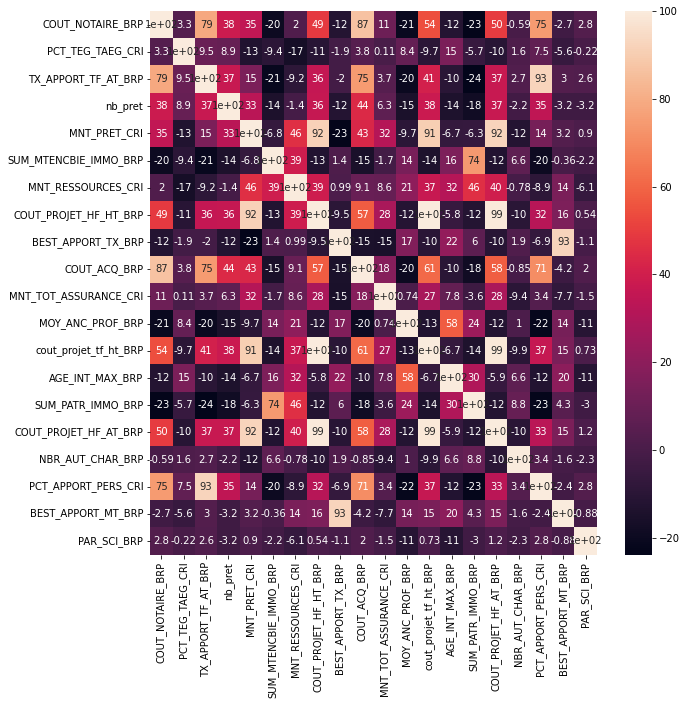

In [159]:
""" Détection de multicolinéarité: matrice de corrélation """
plt.figure(figsize = (10,10))
sns.heatmap(X_train[first_selection_quantitative].corr(method = 'spearman')*100 , annot = True) 

Plusieurs variables semblent générer de la multicolinéarité, on va donc les supprimer:
- [A COMPLETER]

In [160]:
first_selection_quantitative=['MNT_PRET_CRI','PCT_TEG_TAEG_CRI','nb_pret','BEST_APPORT_TX_BRP','COUT_NOTAIRE_BRP','SUM_PATR_IMMO_BRP','SUM_RESS_REVENUS_BRP','MOY_ANC_PROF_BRP','MNT_TOT_ASSURANCE_CRI','PAR_SCI_BRP',"SUM_MTENCBIE_IMMO_BRP",'AGE_INT_MAX_BRP','COUT_PROJET_HF_AT_BRP','MNT_COUT_TOT_CREDIT_CRI','quotite','COUT_RACHAT_BRP']

<AxesSubplot: >

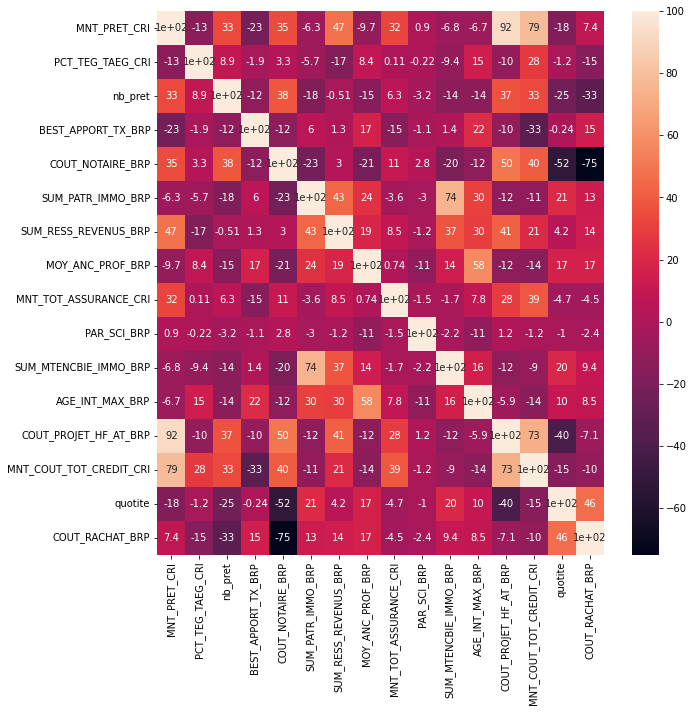

In [161]:
# heatmap apres suppressions des variables qui causent de la multi colinéarité 
plt.figure(figsize = (10,10))
sns.heatmap(X_train[first_selection_quantitative].corr(method = 'spearman')*100 , annot = True) 

#### Sur l'ensemble des variables:

In [162]:
""" Aperçu du Lasso sur l'ensemble (pas optimal pour avoir une vue générale des variables)"""

selection_avec_lasso(X_train,y,20,'all')


,coef
IRPAR_USAGE_V12_MAX_8.0,0.844022
IRPAR_USAGE_V12_MAX_1.0,0.648833
IRPAR_USAGE_V12_MAX_2.0,0.516739
CODTYP_CRT_TRAVAIL_CRI_4,0.456730
IRPAR_USAGE_V12_MAX_3.0,0.436506
COD_SITU_LOGT_CRI_20.0,0.388909
TOP_PRET_RELAIS_BRP_1,0.372038
COD_SITU_LOGT_CRI_10.0,0.369126
IND_PRIMO_ACCEDT_CRI_1.0,0.354329
COD_CSP_BRP_5500.0,0.337544


['IRPAR_USAGE_V12_MAX_8.0',
 'IRPAR_USAGE_V12_MAX_1.0',
 'IRPAR_USAGE_V12_MAX_2.0',
 'CODTYP_CRT_TRAVAIL_CRI_4',
 'IRPAR_USAGE_V12_MAX_3.0',
 'COD_SITU_LOGT_CRI_20.0',
 'TOP_PRET_RELAIS_BRP_1',
 'COD_SITU_LOGT_CRI_10.0',
 'IND_PRIMO_ACCEDT_CRI_1.0',
 'COD_CSP_BRP_5500.0',
 'COD_ETA_BIEN_CRI_60',
 'COD_ETA_BIEN_CRI_20',
 'PCT_TEG_TAEG_CRI',
 'CODTYP_CRT_TRAVAIL_CRI_Y',
 'IRPRO_USAGE_V12_MAX_nan',
 'COUT_NOTAIRE_BRP',
 'IRPAR_USAGE_V12_MAX_6.0',
 'COD_SIT_FAM_EMPRUNTEUR_CRI_3.0',
 'PCT_APPORT_PERS_CRI',
 'nb_pret']

## Discrétisation  + regroupement de modalités 
Dans cette partie, on se charge de:
-  discrétiser les variables quantitatives en modalités 
-  réduire le nombre de modalités pour les variables qualitatives (trop de modalités ==> surapprentissage)

In [163]:
print("Les variables qualitatives sont:",first_selection_quantitative)
print()
print("Les variables quantitatives sont:",first_selection_qualitative)

Les variables qualitatives sont: ['MNT_PRET_CRI', 'PCT_TEG_TAEG_CRI', 'nb_pret', 'BEST_APPORT_TX_BRP', 'COUT_NOTAIRE_BRP', 'SUM_PATR_IMMO_BRP', 'SUM_RESS_REVENUS_BRP', 'MOY_ANC_PROF_BRP', 'MNT_TOT_ASSURANCE_CRI', 'PAR_SCI_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'AGE_INT_MAX_BRP', 'COUT_PROJET_HF_AT_BRP', 'MNT_COUT_TOT_CREDIT_CRI', 'quotite', 'COUT_RACHAT_BRP']

Les variables quantitatives sont: ['COD_CPPOP_CRI', 'COD_ETA_BIEN_CRI', 'COD_USAGE_BIEN_CRI', 'TOP_ETR_BRP', 'TOP_PRET_RELAIS_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'IRPAR_USAGE_V12_MAX', 'IRPRO_USAGE_V12_MAX', 'COD_CSP_BRP', 'TOP_ASC_DESC_BRP', 'QUA_INT_1_BRP', 'QUA_INT_MAX_BRP', 'CODTYP_CRT_TRAVAIL_CRI', 'COD_SITU_LOGT_CRI', 'COD_SIT_FAM_EMPRUNTEUR_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_PRIMO_ACCEDT_CRI', 'TOP_NAT_FR_CRI', 'CSP_RGP_BRP', 'top_pret_int_ext']


### Regroupement des modalités pour les variables catégorielles


#### Nécessaire de regrouper des modalités?
Sans exception, toutes les variables qualitatives sont catégorielles. On va regarder le nombre de modalités pour chacune d'entre elles


Certaines variables ont trop (surapprentissage) ou pas assez de modalités (nombre de modalités =1 => aucune discrimination):
- On ne traite pas la CSP avec bcp de modalités (l'autre variable CSP disponible est plus pertinente et a le bon nombre de modalité)
- la variable STA qui n'a pas de modalités interprétables
- ROL_INT_MAX n'a pas plus d'une modalité


In [164]:
drop_columns(X_train,["STA_CLP_BRP","ROL_INT_MAX_BRP","TOP_CONNU_BRP"]+X_train.drop(columns=first_selection_qualitative).select_dtypes(include="object").columns.tolist())

Ces colonnes vont être retirées: ['STA_CLP_BRP', 'ROL_INT_MAX_BRP', 'TOP_CONNU_BRP', 'TOP_CONNU_BRP', 'TOP_SCI_BRP', 'NBR_INT_BRP', 'NBR_TOT_COEMPR_CRI', 'CODTYPE_PROJET_CRI', 'STA_CLP_BRP', 'ROL_INT_MAX_BRP', 'IND_INCIDENT_BDF_CRI', 'NBR_ENF_ACHARGE_CRI', 'NBR_OCCUP_CRI', 'TOP_BIEN_FR_CRI', 'top_locatif', 'top_autre_pret_int', 'top_autre_pret_ext', 'top_pers_seule']


,nb_pret,COD_CPPOP_CRI,COD_ETA_BIEN_CRI,COD_USAGE_BIEN_CRI,BEST_APPORT_MT_BRP,BEST_APPORT_TX_BRP,PCT_APPORT_PERS_CRI,PCT_ENDETTMT_CRI,TOP_ETR_BRP,TOP_PRET_RELAIS_BRP,...,MNT_PRET_ENC_LCL_CRI,SUM_IMPO_REV_BRP,SUM_TAX_FISC_BRP,SUM_MNT_PRE_EXTERNE_BRP,TOP_NAT_FR_CRI,CSP_RGP_BRP,Mt_credit_nb_ans_rev_prof,financement_tot,quotite,top_pret_int_ext
87129,2,10,60,10,115000.00,36.51,0,37.78456,0,0,...,0.0,1391.0,1500.0,0.00,1,3.0,16.056519,200000.00,0.655738,0
25472,1,70,60,10,128700.00,48.57,1,39.57397,0,0,...,0.0,1389.0,1000.0,0.00,1,5.0,4.921644,136300.00,1.035699,0
70507,1,130,40,10,16647.88,6.05,0,25.17245,0,0,...,0.0,6463.0,0.0,0.00,1,3.0,4.306012,258352.12,1.016558,0
27802,1,130,50,10,14795.04,9.48,0,28.38454,0,0,...,0.0,4986.0,0.0,15.00,1,5.0,4.548798,126724.96,1.017667,0
17760,1,10,60,10,500.00,0.29,2,29.28553,0,0,...,0.0,3948.0,2177.0,463.99,1,3.0,2.817943,171810.00,0.997098,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,1,70,60,40,8203.44,7.96,0,33.93987,0,0,...,0.0,2634.0,1256.0,0.00,1,6.0,5.398745,94796.56,1.040331,0
58186,1,70,40,40,52717.25,40.55,0,40.68923,0,0,...,0.0,4800.0,150.0,700.00,1,3.0,1.259497,77282.75,1.035251,0
29500,1,70,60,10,48200.00,24.10,1,50.65287,0,0,...,0.0,3471.0,977.0,928.33,1,3.0,3.457938,151800.00,1.029398,0
23007,1,130,60,10,1445.66,1.70,0,38.95448,0,0,...,0.0,521.0,800.0,68.98,1,4.0,5.239502,83554.34,1.033393,0


#### Regroupement des modalités

 Avant regroupement: On regarde si certaines sont déja non significatives. Si jamais on vient à toucher aux modalités, c'est important de vérifier que ce n'est pas l'encodage qui a fait ça


##### Regroupement des modalités manuellement
- On récupère la liste des variables ayant plus de 5 modalités: il s'agit d'un seuil arbitraire, qui selon nous, semble pertinent. En effet, lorsqu'il y a trop de modalités, qui ont, qui plus est, peu d'observations, il convient de les regrouper pour éviter du surapprentissage

La priorité est de traiter les variables ayant trop de modalités (>8). D'une part on va renommer les catégories et effectuer un rassemblement de certaines modalités à la main. Dans un second temps, on va procéder à une sélection automatique. A la fin, on aura l'ensemble des variables catégorielles qui ont encore plus d'une modalité. 

In [165]:
def selection_categorical_var_post_grouping(X_train:pd.DataFrame,y:pd.Series,seuil_diff_tx_moyen:np.float) -> list:
    """ retourne la liste des variables qui ne sont pas discriminantes post-regroupement (pas assez de modalités ou taux de différence entre modalité pas suffisant)
    Argument: 
        - X_train: x_train avec quali sélectionnées
        - y
        - seuil_diff_tx_moyen: taux de différence (ici 0.001)
    Rq: on a laissé apparente uniquement les variables sélectionnées à la fin de ce notebook 
    """  
    quali_no_discriminant=[]
    for col in X_train.columns.tolist():
        test=pd.concat([y.reset_index(drop=True),X_train[col].reset_index(drop=True)],axis=1)
        moyenne_defaut_per_mod=test.groupby([col])["defaut_36mois"].agg("mean").sort_values()
        if X_train[col].nunique()<2:
            quali_no_discriminant.append(col)
        elif moyenne_defaut_per_mod.diff().abs().min()<seuil_diff_tx_moyen:
            quali_no_discriminant.append(col)

    return quali_no_discriminant



    

def replace_encoding_by_real_labels(X: pd.DataFrame)-> pd.DataFrame:

    """ retourne le dataframe avec variables encodées avec leurs intitulés dans le lexique
    Argument: 
        - X
    Rq: on a laissé apparente uniquement les variables sélectionnées à la fin de ce notebook 
    """  

    COD_ETA_BIEN_CRI={"10":"neuf",
    "20":"vente en état futur d'achèvement",
    "30":"contrat construction maison individuelle",
    "40":"ancien_inf_10_ans",
    "60":"ancien_sup_10_ans",
    "50":"ancien_sup_10_ans",
    "70":"clé en main avec levée d'option"}


    CODTYP_CRT_TRAVAIL_CRI={"1":"cdi et professions libérales",
    "2":"cdi et professions libérales",
    "3":"cdd et intérim",
    "4":"fonctionnaire ou agent public",
    "5":"fonctionnaire ou agent public",
    "6":"fonctionnaire ou agent public",
    "7":"cdd et intérim","8":"chomage, retraités, inactifs",
    "9":"chomage, retraités, inactifs",
    "A":"fonctionnaire ou agent public",
    "B":"fonctionnaire ou agent public",
    "Y":"chomage, retraités, inactifs",
    "Z":"cdi et professions libérales"}

    COD_SITU_LOGT_CRI={"10.0":"propriétaire",
    "20.0":"propriétaire accédant",
    "30.0":"locataire hlm",
    "40.0":"locataire autre",
    "50.0":"locataire de fonction",
    "60.0":"occupant gratuit",
    "70.0":"logement parents",
    "nan":"autres",
    "900.°":"autres"}

    COD_CPPOP_CRI={"10":"ACQUISITION_SEULE",
    "20":"ACQUISITION_TRAVAUX",
    "70":"RACHAT_DE_PRET",
    "30":"TERRAIN_CONSTRUCTION",
    "40":"CONSTRUCTION_SEULE",
    "60":"TRAVAUX",
    "50":"TRAVAUX_CONSTRUCTION",
    "80":"PAIEMENT_SOULTE",
    "90":"PAIEMENT_SOULTE_TRAVAUX",
    "110":"RACHAT_DE_PRET",
    "130":"RACHAT_DE_PRET"}


    COD_TYPE_MARCHE_CRI={"M1":"M1",
    "M21":"M2",
    "M2":"M2"}


    # Replace with map function from dict values
    try:
        X["COD_ETA_BIEN_CRI"]=X["COD_ETA_BIEN_CRI"].map(COD_ETA_BIEN_CRI)
    except:
        print("Check COD_ETA_BIEN_CRI is selected")

    try:
        X["CODTYP_CRT_TRAVAIL_CRI"]=X["CODTYP_CRT_TRAVAIL_CRI"].map(CODTYP_CRT_TRAVAIL_CRI)
    except:
        print("Check CODTYP_CRT_TRAVAIL_CRI is selected")
    try:
        X["COD_SITU_LOGT_CRI"]=X["COD_SITU_LOGT_CRI"].map(COD_SITU_LOGT_CRI)
    except:
        print("Check COD_SITU_LOGT_CRI is selected")
    try:
        X["COD_TYPE_MARCHE_CRI"]=X["COD_TYPE_MARCHE_CRI"].map(COD_TYPE_MARCHE_CRI)
    except:
        print("Check COD_TYPE_MARCHE_CRI is selected")
    try:
        X["COD_CPPOP_CRI"]=X["COD_CPPOP_CRI"].map(COD_CPPOP_CRI)
    except:
        print("Check COD_CPPOP_CRI is selected")


    return X

In [166]:
replace_encoding_by_real_labels(X_train)


,nb_pret,COD_CPPOP_CRI,COD_ETA_BIEN_CRI,COD_USAGE_BIEN_CRI,BEST_APPORT_MT_BRP,BEST_APPORT_TX_BRP,PCT_APPORT_PERS_CRI,PCT_ENDETTMT_CRI,TOP_ETR_BRP,TOP_PRET_RELAIS_BRP,...,MNT_PRET_ENC_LCL_CRI,SUM_IMPO_REV_BRP,SUM_TAX_FISC_BRP,SUM_MNT_PRE_EXTERNE_BRP,TOP_NAT_FR_CRI,CSP_RGP_BRP,Mt_credit_nb_ans_rev_prof,financement_tot,quotite,top_pret_int_ext
87129,2,ACQUISITION_SEULE,ancien_sup_10_ans,10,115000.00,36.51,0,37.78456,0,0,...,0.0,1391.0,1500.0,0.00,1,3.0,16.056519,200000.00,0.655738,0
25472,1,RACHAT_DE_PRET,ancien_sup_10_ans,10,128700.00,48.57,1,39.57397,0,0,...,0.0,1389.0,1000.0,0.00,1,5.0,4.921644,136300.00,1.035699,0
70507,1,RACHAT_DE_PRET,ancien_inf_10_ans,10,16647.88,6.05,0,25.17245,0,0,...,0.0,6463.0,0.0,0.00,1,3.0,4.306012,258352.12,1.016558,0
27802,1,RACHAT_DE_PRET,ancien_sup_10_ans,10,14795.04,9.48,0,28.38454,0,0,...,0.0,4986.0,0.0,15.00,1,5.0,4.548798,126724.96,1.017667,0
17760,1,ACQUISITION_SEULE,ancien_sup_10_ans,10,500.00,0.29,2,29.28553,0,0,...,0.0,3948.0,2177.0,463.99,1,3.0,2.817943,171810.00,0.997098,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,1,RACHAT_DE_PRET,ancien_sup_10_ans,40,8203.44,7.96,0,33.93987,0,0,...,0.0,2634.0,1256.0,0.00,1,6.0,5.398745,94796.56,1.040331,0
58186,1,RACHAT_DE_PRET,ancien_inf_10_ans,40,52717.25,40.55,0,40.68923,0,0,...,0.0,4800.0,150.0,700.00,1,3.0,1.259497,77282.75,1.035251,0
29500,1,RACHAT_DE_PRET,ancien_sup_10_ans,10,48200.00,24.10,1,50.65287,0,0,...,0.0,3471.0,977.0,928.33,1,3.0,3.457938,151800.00,1.029398,0
23007,1,RACHAT_DE_PRET,ancien_sup_10_ans,10,1445.66,1.70,0,38.95448,0,0,...,0.0,521.0,800.0,68.98,1,4.0,5.239502,83554.34,1.033393,0


#### Regroupement des modalités automatiquement
- On a crée un algorithme qui permet de rassembler les modalités si elles ne sont pas assez remplies ou ne sont pas significatives.
- Deux objectifs: diminuer nombre de modalités et vérifier leur pertinence
- Si une modalités comporte moins de 5% ==> on doit la merge avec une autre modalité = on tente par modalité ayant la moyenne la plus proche
- Si la variable la plus proche n'est pas plus importante, alors on prend la classe majoritaire

In [167]:
""" REGROUPEMENT DES MODALITES + CREATION D'UN JSON (UTILISE POUR LA PIPELINE POUR ENCODER DE LA MEME MANIERE ) """

dict_encoding=group_modalities_with_optbinning(X_train,y,first_selection_qualitative,0.05,0.001,True)

################################ COD_CPPOP_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[RACHAT_DE_PRET],34635,0.507725,34509,126,0.003638,0.573215,0.127333,0.015702
1,[ACQUISITION_SEULE],27427,0.402061,27205,222,0.008094,-0.231,0.024094,0.003005
2,"[ACQUISITION_TRAVAUX, TRAVAUX, TERRAIN_CONSTRU...",6154,0.090213,6063,91,0.014787,-0.840378,0.099025,0.012026
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.250453,0.030734


ENCODING...
################################ COD_ETA_BIEN_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[ancien_inf_10_ans, vente en état futur d'achè...",18682,0.273865,18602,80,0.004282,0.409519,0.037769,0.004688
1,[ancien_sup_10_ans],47174,0.691539,46834,340,0.007207,-0.11406,0.009522,0.001190
2,"[neuf, contrat construction maison individuell...",2281,0.033438,2264,17,0.007453,-0.147804,0.000786,0.000098
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,79,0.001158,77,2,0.025316,-1.388821,0.004749,0.000550
Totals,,68216,1.000000,67777,439,0.006435,,0.052827,0.006526


ENCODING...
################################ COD_USAGE_BIEN_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[40, 10]",65985,0.967295,65561,424,0.006426,0.001524,0.000002,2.806381e-07
1,"[20, 50, 60, 30]",2231,0.032705,2216,15,0.006723,-0.04407,0.000065,8.114312e-06
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,68216,1.000000,67777,439,0.006435,,0.000067,8.394950e-06


ENCODING...
################################ TOP_ETR_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],64825,0.95029,64427,398,0.006140,0.047357,0.002082,0.000260
1,[1],3391,0.04971,3350,41,0.012091,-0.636335,0.027978,0.003439
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.00000,67777,439,0.006435,,0.030060,0.003700


ENCODING...
################################ TOP_PRET_RELAIS_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],67327,0.986968,66905,422,0.006268,0.026545,0.000686,0.000086
1,[1],889,0.013032,872,17,0.019123,-1.101903,0.028494,0.003392
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.029180,0.003478


ENCODING...
################################ TOP_SURFINANCEMENT_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],57680,0.845549,57335,345,0.005981,0.073643,0.004423,0.000553
1,[1],10536,0.154451,10442,94,0.008922,-0.329182,0.019770,0.002460
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.024193,0.003013


ENCODING...
################################ top_exist_conso_revo_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],52384,0.767914,52070,314,0.005994,0.071472,0.003788,0.000473
1,[1],15832,0.232086,15707,125,0.007895,-0.205931,0.010913,0.001362
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.014700,0.001835


ENCODING...
################################ IRPAR_USAGE_V12_MAX ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[2.0, 3.0]",52159,0.764615,51898,261,0.005004,0.253036,0.043316,0.005400
1,[4.0],5441,0.079761,5394,47,0.008638,-0.296584,0.008149,0.001015
2,"[6.0, 1.0, 5.0, 8.0, 7.0, nan, 9.0, 10.0]",10616,0.155623,10485,131,0.012340,-0.656975,0.094412,0.011594
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.145877,0.018009


ENCODING...
################################ IRPRO_USAGE_V12_MAX ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[nan],66834,0.979741,66418,416,0.006224,0.033559,0.001085,0.000136
1,"[5.0, 1.0, 3.0, 7.0, 2.0, 4.0, 8.0, 6.0, 9.0, ...",1382,0.020259,1359,23,0.016643,-0.960469,0.031062,0.003740
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.032148,0.003876


ENCODING...
################################ COD_CSP_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[5100.0, 3600.0, 5400.0, 4700.0]",43963,0.644468,43711,252,0.005732,0.116447,0.008255,0.001031
1,"[6100.0, 5500.0]",9856,0.144482,9769,87,0.008827,-0.318418,0.017208,0.002142
2,"[3300.0, 4600.0, 4300.0, 2330.0, 4500.0, 5600....",14397,0.211050,14297,100,0.006946,-0.076844,0.001295,0.000162
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.026758,0.003335


ENCODING...
################################ TOP_ASC_DESC_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],68084,0.998065,67651,433,0.006360,0.011901,0.000141,0.000018
1,[1],132,0.001935,126,6,0.045455,-1.994956,0.023557,0.002537
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.023698,0.002554


ENCODING...
################################ QUA_INT_1_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[4],9364,0.137270,9321,43,0.004592,0.339346,0.013430,0.001671
1,[2],53139,0.778981,52791,348,0.006549,-0.017585,0.000243,0.000030
2,[3],5141,0.075364,5095,46,0.008948,-0.332105,0.009834,0.001224
3,[5],572,0.008385,570,2,0.003497,0.61301,0.002363,0.000291
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.025869,0.003215


ENCODING...
################################ QUA_INT_MAX_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[4],12421,0.182083,12364,57,0.004589,0.340014,0.017878,0.002224
1,"[2, 3]",55223,0.809531,54843,380,0.006881,-0.06742,0.003805,0.000476
2,[5],572,0.008385,570,2,0.003497,0.61301,0.002363,0.000291
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.024046,0.002990


ENCODING...
################################ CODTYP_CRT_TRAVAIL_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[fonctionnaire ou agent public],11618,0.170312,11571,47,0.004045,0.466631,0.029706,0.003680
1,[cdi et professions libérales],54795,0.803257,54423,372,0.006789,-0.05383,0.002391,0.000299
2,"[chomage, retraités, inactifs, cdd et intérim]",1803,0.026431,1783,20,0.011093,-0.549158,0.010572,0.001305
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.042668,0.005284


ENCODING...
################################ COD_SITU_LOGT_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[propriétaire accédant, propriétaire]",45269,0.663613,45054,215,0.004749,0.3055,0.053459,0.006657
1,[locataire autre],15728,0.230562,15568,160,0.010173,-0.46168,0.062221,0.007709
2,"[logement parents, occupant gratuit, locataire...",7197,0.105503,7135,62,0.008615,-0.293846,0.010566,0.001316
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,22,0.000323,20,2,0.090909,-2.736894,0.011661,0.001125
Totals,,68216,1.000000,67777,439,0.006435,,0.137907,0.016807


ENCODING...
################################ COD_SIT_FAM_EMPRUNTEUR_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[3.0],14709,0.215624,14638,71,0.004827,0.289218,0.015688,0.001954
1,[1.0],18787,0.275405,18670,117,0.006228,0.033021,0.000295,0.000037
2,"[5.0, 2.0]",33370,0.489181,33128,242,0.007252,-0.120282,0.007514,0.000939
3,"[nan, 6.0, 4.0]",1350,0.019790,1341,9,0.006667,-0.035532,0.000025,0.000003
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.023523,0.002933


ENCODING...
################################ COD_TYPE_MARCHE_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[M1],63981,0.937918,63585,396,0.006189,0.03924,0.001417,0.000177
1,[M2],4235,0.062082,4192,43,0.010153,-0.459746,0.016597,0.002057
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.018013,0.002234


ENCODING...
################################ IND_PRIMO_ACCEDT_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[nan, 2.0]",55766,0.817491,55452,314,0.005631,0.134401,0.013829,0.001727
1,[1.0],12450,0.182509,12325,125,0.010040,-0.448408,0.046137,0.005719
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.059966,0.007447


ENCODING...
################################ TOP_NAT_FR_CRI ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1],66046,0.968189,65634,412,0.006238,0.031347,0.000937,0.000117
1,[0],2170,0.031811,2143,27,0.012442,-0.665354,0.019884,0.002441
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.020821,0.002558


ENCODING...
################################ CSP_RGP_BRP ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[4.0, 3.0, 5.0]",60529,0.887314,60162,367,0.006063,0.059956,0.003097,0.000387
1,[6.0],4688,0.068723,4648,40,0.008532,-0.284166,0.006405,0.000798
2,"[2.0, 7.0, nan, 8.0, 1.0]",2999,0.043963,2967,32,0.010670,-0.509908,0.014847,0.001836
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.000000,67777,439,0.006435,,0.024349,0.003021


ENCODING...
################################ top_pret_int_ext ################################
STATUS : OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],64707,0.94856,64301,406,0.006274,0.025499,0.000609,0.000076
1,[1],3509,0.05144,3476,33,0.009404,-0.382349,0.009132,0.001135
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,68216,1.00000,67777,439,0.006435,,0.009741,0.001211


ENCODING...


In [168]:
def encoding_categorical_variables(X:pd.DataFrame,dict_encoding:dict,list_quali_var:list):

    for col in list_quali_var:
        X[col]=X[col].fillna(X[col].mode()[0])
        X[col].replace(dict_encoding[col], inplace=True)
        mod=X[col].mode()[0]
        X[col]=X[col].apply(lambda x: replace_by_mod_if_not_encoded(x,dict_encoding[col].values(),mod))
        X[col]=X[col].fillna(X[col].mode()[0])
        X[col]=X[col].astype("category")

def replace_by_mod_if_not_encoded(x,dict_encoding_values,mod):
    if x not in dict_encoding_values:
        x=mod
    else:
        x=x
    return x

In [169]:
""" ENCODAGE VARIABLES CATEGORIELLES SELON LE DICTIONNAIRE"""
encoding_categorical_variables(X_train,dict_encoding,first_selection_qualitative)


In [188]:
quali_selected_variables=['COD_CPPOP_CRI',
 'TOP_ETR_BRP',
 'TOP_PRET_RELAIS_BRP',
 'TOP_SURFINANCEMENT_BRP',
 'top_exist_conso_revo_BRP',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'COD_CSP_BRP',
 'TOP_ASC_DESC_BRP',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'CSP_RGP_BRP',
 'top_pret_int_ext']

In [170]:
no_discriminant_cat_var=selection_categorical_var_post_grouping(X_train[first_selection_qualitative],y,0.001)
print("Variables non significatives post-sélection:", no_discriminant_cat_var)
#drop_columns(X_train,no_discriminant_cat_var)

Variables non significatives post-sélection: ['COD_ETA_BIEN_CRI', 'COD_USAGE_BIEN_CRI', 'COD_SIT_FAM_EMPRUNTEUR_CRI']
Ces colonnes vont être retirées: ['COD_ETA_BIEN_CRI', 'COD_USAGE_BIEN_CRI', 'COD_SIT_FAM_EMPRUNTEUR_CRI']


,nb_pret,COD_CPPOP_CRI,BEST_APPORT_MT_BRP,BEST_APPORT_TX_BRP,PCT_APPORT_PERS_CRI,PCT_ENDETTMT_CRI,TOP_ETR_BRP,TOP_PRET_RELAIS_BRP,TX_APPORT_HF_AT_BRP,TX_APPORT_HF_HT_BRP,...,MNT_PRET_ENC_LCL_CRI,SUM_IMPO_REV_BRP,SUM_TAX_FISC_BRP,SUM_MNT_PRE_EXTERNE_BRP,TOP_NAT_FR_CRI,CSP_RGP_BRP,Mt_credit_nb_ans_rev_prof,financement_tot,quotite,top_pret_int_ext
87129,2,0,115000.00,36.51,0,37.78456,0,0,0.344262,0.344262,...,0.0,1391.0,1500.0,0.00,1,1,16.056519,200000.00,0.655738,0
25472,1,2,128700.00,48.57,1,39.57397,0,0,-0.035699,-0.035699,...,0.0,1389.0,1000.0,0.00,1,1,4.921644,136300.00,1.035699,0
70507,1,2,16647.88,6.05,0,25.17245,0,0,-0.016558,-0.016558,...,0.0,6463.0,0.0,0.00,1,1,4.306012,258352.12,1.016558,0
27802,1,2,14795.04,9.48,0,28.38454,0,0,-0.017667,-0.017667,...,0.0,4986.0,0.0,15.00,1,1,4.548798,126724.96,1.017667,0
17760,1,0,500.00,0.29,2,29.28553,0,0,0.002902,0.002902,...,0.0,3948.0,2177.0,463.99,1,1,2.817943,171810.00,0.997098,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,1,2,8203.44,7.96,0,33.93987,0,0,-0.040331,-0.040331,...,0.0,2634.0,1256.0,0.00,1,2,5.398745,94796.56,1.040331,0
58186,1,2,52717.25,40.55,0,40.68923,0,0,-0.035251,-0.035251,...,0.0,4800.0,150.0,700.00,1,1,1.259497,77282.75,1.035251,0
29500,1,2,48200.00,24.10,1,50.65287,0,0,-0.029398,-0.029398,...,0.0,3471.0,977.0,928.33,1,1,3.457938,151800.00,1.029398,0
23007,1,2,1445.66,1.70,0,38.95448,0,0,-0.033393,-0.033393,...,0.0,521.0,800.0,68.98,1,1,5.239502,83554.34,1.033393,0


### Discrétisation des variables quantitatives


In [173]:
discretisation_variables_from_chi2(X_train)


,nb_pret,COD_CPPOP_CRI,BEST_APPORT_MT_BRP,BEST_APPORT_TX_BRP,PCT_APPORT_PERS_CRI,PCT_ENDETTMT_CRI,TOP_ETR_BRP,TOP_PRET_RELAIS_BRP,TX_APPORT_HF_AT_BRP,TX_APPORT_HF_HT_BRP,...,g_quotite,g_PCT_TEG_TAEG_CRI,g_MOY_ANC_PROF_BRP,g_nb_pret,g_MNT_COUT_TOT_CREDIT_CRI,g_BEST_APPORT_TX_BRP,g_COUT_PROJET_HF_AT_BRP,g_SUM_MTENCBIE_IMMO_BRP,g_MNT_PRET_CRI,g_AGE_INT_MAX_BRP
87129,2,0,115000.00,36.51,0,37.78456,0,0,0.344262,0.344262,...,grp_1,grp_2,grp_1,grp_1,grp_2,grp_1,grp_3,grp_3,grp_2,grp_1
25472,1,2,128700.00,48.57,1,39.57397,0,0,-0.035699,-0.035699,...,grp_1,grp_4,grp_1,grp_2,grp_2,grp_1,grp_2,grp_3,grp_2,grp_1
70507,1,2,16647.88,6.05,0,25.17245,0,0,-0.016558,-0.016558,...,grp_2,grp_2,grp_2,grp_2,grp_2,grp_3,grp_2,grp_3,grp_2,grp_1
27802,1,2,14795.04,9.48,0,28.38454,0,0,-0.017667,-0.017667,...,grp_2,grp_4,grp_2,grp_2,grp_3,grp_2,grp_2,grp_1,grp_1,grp_1
17760,1,0,500.00,0.29,2,29.28553,0,0,0.002902,0.002902,...,grp_4,grp_4,grp_1,grp_2,grp_3,grp_4,grp_2,grp_3,grp_2,grp_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,1,2,8203.44,7.96,0,33.93987,0,0,-0.040331,-0.040331,...,grp_1,grp_2,grp_3,grp_2,grp_1,grp_2,grp_1,grp_3,grp_1,grp_1
58186,1,2,52717.25,40.55,0,40.68923,0,0,-0.035251,-0.035251,...,grp_1,grp_1,grp_3,grp_2,grp_1,grp_1,grp_2,grp_1,grp_2,grp_1
29500,1,2,48200.00,24.10,1,50.65287,0,0,-0.029398,-0.029398,...,grp_1,grp_2,grp_2,grp_2,grp_2,grp_2,grp_2,grp_2,grp_2,grp_1
23007,1,2,1445.66,1.70,0,38.95448,0,0,-0.033393,-0.033393,...,grp_1,grp_3,grp_2,grp_2,grp_1,grp_4,grp_2,grp_3,grp_1,grp_1


Vérification que la discrétisation est pertinente avec : 
- un groupby par moyenne de défaut pour chaque variable 
- un test du khi2 

In [174]:
check_mean_defaut_rate_per_category(X_train,y)

------ pour la variable g_MNT_TOT_ASSURANCE_CRI : 



g_MNT_TOT_ASSURANCE_CRI
grp_1    199
grp_2    118
grp_3    122
Name: 1, dtype: int64


------ pour la variable g_COUT_RACHAT_BRP : 



g_COUT_RACHAT_BRP
grp_1     83
grp_2     39
grp_3    317
Name: 1, dtype: int64


------ pour la variable g_SUM_PATR_IMMO_BRP : 



g_SUM_PATR_IMMO_BRP
grp_1     45
grp_2    394
Name: 1, dtype: int64


------ pour la variable g_quotite : 



g_quotite
grp_1    146
grp_2     49
grp_3    133
grp_4    111
Name: 1, dtype: int64


------ pour la variable g_PCT_TEG_TAEG_CRI : 



g_PCT_TEG_TAEG_CRI
grp_1     27
grp_2     88
grp_3    136
grp_4    188
Name: 1, dtype: int64


------ pour la variable g_MOY_ANC_PROF_BRP : 



g_MOY_ANC_PROF_BRP
grp_1    174
grp_2    103
grp_3    162
Name: 1, dtype: int64


------ pour la variable g_nb_pret : 



g_nb_pret
grp_1    107
grp_2    332
Name: 1, dtype: int64


------ pour la variable g_MNT_COUT_TOT_CREDIT_CRI : 



g_MNT_COUT_TOT_CREDIT_CRI
grp_1    166
grp_2    101
grp_3    172
Name: 1, dtype: int64


------ pour la variable g_BEST_APPORT_TX_BRP : 



g_BEST_APPORT_TX_BRP
grp_1     54
grp_2    102
grp_3    169
grp_4    114
Name: 1, dtype: int64


------ pour la variable g_COUT_PROJET_HF_AT_BRP : 



g_COUT_PROJET_HF_AT_BRP
grp_1     43
grp_2    330
grp_3     66
Name: 1, dtype: int64


------ pour la variable g_SUM_MTENCBIE_IMMO_BRP : 



g_SUM_MTENCBIE_IMMO_BRP
grp_1     39
grp_2     48
grp_3    352
Name: 1, dtype: int64


------ pour la variable g_MNT_PRET_CRI : 



g_MNT_PRET_CRI
grp_1     93
grp_2    270
grp_3     76
Name: 1, dtype: int64


------ pour la variable g_AGE_INT_MAX_BRP : 



g_AGE_INT_MAX_BRP
grp_1    310
grp_2    129
Name: 1, dtype: int64

In [175]:
quanti_selected_variables=X_train.select_dtypes(include=['object']).columns.tolist()
quanti_selected_variables_basename=[quanti[2:] for quanti in quanti_selected_variables ]
print('Colonnes sélectionnées (avec noms initiaux)',quanti_selected_variables_basename)

Colonnes sélectionnées (avec noms initiaux) ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']


## Overview de la sélection de variables
- Quelles sont les variables finalement retenues?
- Etude de la stabilité temporelles
 

In [176]:
quali_selected_variables

['COD_CPPOP_CRI',
 'TOP_ETR_BRP',
 'TOP_PRET_RELAIS_BRP',
 'TOP_SURFINANCEMENT_BRP',
 'top_exist_conso_revo_BRP',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'COD_CSP_BRP',
 'TOP_ASC_DESC_BRP',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI']

In [189]:
X_train_selection=X_train[quali_selected_variables+quanti_selected_variables]

In [190]:
X_train_selection

,COD_CPPOP_CRI,TOP_ETR_BRP,TOP_PRET_RELAIS_BRP,TOP_SURFINANCEMENT_BRP,top_exist_conso_revo_BRP,IRPAR_USAGE_V12_MAX,IRPRO_USAGE_V12_MAX,COD_CSP_BRP,TOP_ASC_DESC_BRP,QUA_INT_1_BRP,...,g_quotite,g_PCT_TEG_TAEG_CRI,g_MOY_ANC_PROF_BRP,g_nb_pret,g_MNT_COUT_TOT_CREDIT_CRI,g_BEST_APPORT_TX_BRP,g_COUT_PROJET_HF_AT_BRP,g_SUM_MTENCBIE_IMMO_BRP,g_MNT_PRET_CRI,g_AGE_INT_MAX_BRP
87129,0,0,0,0,0,2,1,0,0,2,...,grp_1,grp_2,grp_1,grp_1,grp_2,grp_1,grp_3,grp_3,grp_2,grp_1
25472,2,0,0,0,0,0,1,1,0,2,...,grp_1,grp_4,grp_1,grp_2,grp_2,grp_1,grp_2,grp_3,grp_2,grp_1
70507,2,0,0,0,0,2,1,0,0,0,...,grp_2,grp_2,grp_2,grp_2,grp_2,grp_3,grp_2,grp_3,grp_2,grp_1
27802,2,0,0,0,0,0,1,1,0,0,...,grp_2,grp_4,grp_2,grp_2,grp_3,grp_2,grp_2,grp_1,grp_1,grp_1
17760,0,0,0,0,1,2,1,1,0,1,...,grp_4,grp_4,grp_1,grp_2,grp_3,grp_4,grp_2,grp_3,grp_2,grp_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80162,2,0,0,0,0,0,1,2,0,0,...,grp_1,grp_2,grp_3,grp_2,grp_1,grp_2,grp_1,grp_3,grp_1,grp_1
58186,2,0,0,0,0,0,1,1,0,0,...,grp_1,grp_1,grp_3,grp_2,grp_1,grp_1,grp_2,grp_1,grp_2,grp_1
29500,2,0,0,0,0,2,1,1,0,0,...,grp_1,grp_2,grp_2,grp_2,grp_2,grp_2,grp_2,grp_2,grp_2,grp_1
23007,2,0,0,0,0,0,1,1,0,0,...,grp_1,grp_3,grp_2,grp_2,grp_1,grp_4,grp_2,grp_3,grp_1,grp_1


### Random Forest: sélection de variables finales
Cela va nous permettre d'avoir des variables encore plus discriminantes pour l'algorithme final


{'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 400}


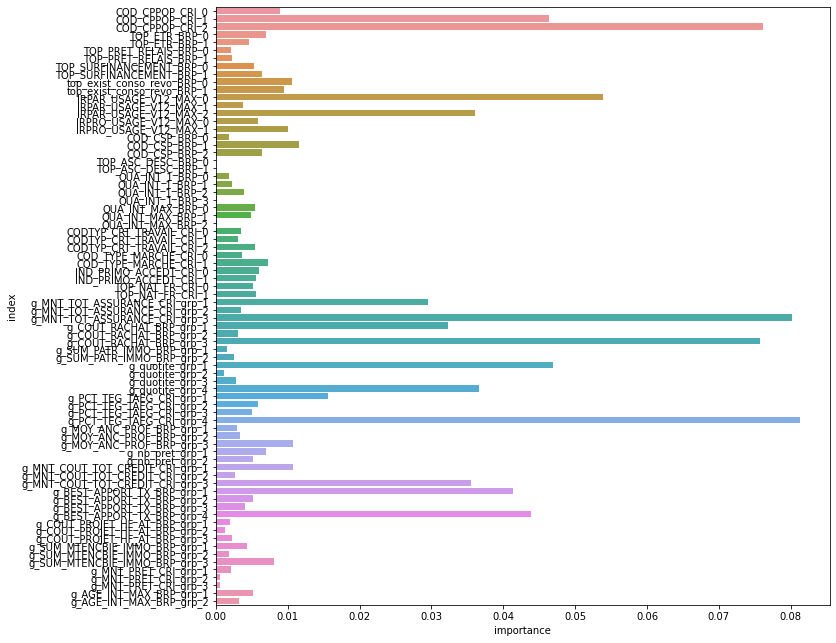

In [179]:
get_feature_selection_rf(X_train_selection,y)


Ainsi, parmi les variables présentées, nous allons garder les suivantes et supprimer les autres. 
[A COMPLETER]

In [197]:
""" Liste exhaustive de colonnes à enlever post-rf """

unselected_columns_for_model=['g_AGE_INT_MAX_BRP',
'g_MNT_PRET_CRI', 
'g_SUM_MTENCBIE_IMMO_BRP', 
'g_COUT_PROJET_HF_AT_BRP',
'TOP_ETR_BRP', 
'TOP_PRET_RELAIS_BRP', 
'TOP_SURFINANCEMENT_BRP' ,
'top_exist_conso_revo_BRP', 
'COD_CSP_BRP',
'CSP_RGP_BRP',
'TOP_ASC_DESC_BRP',
'g_SUM_PATR_IMMO_BRP',
'g_MNT_COUT_TOT_CREDIT_CRI',
'g_nb_pret',
'top_pret_int_ext']


X_selected_with_rf=X_train_selection.drop(columns =unselected_columns_for_model )

In [198]:
selected_variables=X_selected_with_rf.columns.tolist()

In [199]:
selected_variables

['COD_CPPOP_CRI',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'g_MNT_TOT_ASSURANCE_CRI',
 'g_COUT_RACHAT_BRP',
 'g_quotite',
 'g_PCT_TEG_TAEG_CRI',
 'g_MOY_ANC_PROF_BRP',
 'g_BEST_APPORT_TX_BRP']

On doit toujours retrouver cette liste:

['COD_CPPOP_CRI',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'g_MNT_TOT_ASSURANCE_CRI',
 'g_COUT_RACHAT_BRP',
 'g_quotite',
 'g_PCT_TEG_TAEG_CRI',
 'g_MOY_ANC_PROF_BRP',
 'g_BEST_APPORT_TX_BRP',
 'COD_SITU_LOGT_CRI']

Avant de finir ce notebook sur la partie processing, nous allons vérifier la stabilité temporelle de nos features.
A cette occasion, nous allons vous présenter notre pipeline de preprocessing, qui permet de récupérer l'échantillon pré-processé comme l'échantillon d'apprentissage

[STABILITE TEMPORELLE]

### Stabilité temporelle
Application de la pipeline 'preprocessing_pipeline' qui: 

- Variables quantitatives à processer: quanti_selected_variables_basename
- Variables qualitatives à processer quali: quali_selected_variables
- Variables retenues après RF (noms avec gr): selected_variables

In [200]:
stability_data = raw_data.copy() 
y_for_stability=stability_data["defaut_36mois"]
x_for_stability=stability_data.drop(columns="defaut_36mois")
oot_base_clean=df_hors_temps.copy()
y_oot_base_clean=oot_base_clean["defaut_36mois"]
x_oot_base=oot_base_clean.drop(columns="defaut_36mois")
test=X_test.copy()
y_test_clean=test["defaut_36mois"]
x_test=test.drop(columns="defaut_36mois")

In [202]:
stability_data=pipeline_processing(x_for_stability, y_for_stability,quanti_selected_variables_basename,quali_selected_variables,selected_variables,stability_sample=True, training_option=False )

IMPUTATION PAR 0
OK
IMPUTATION PAR MODE OU MEDIANE
OK
DONE
DONE
Check COD_ETA_BIEN_CRI is selected
DONE
Ces colonnes vont être retirées: ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']
DONE


STABILITE DES MODALITES PAR RAPPORT A LA TARGET
STABILITE DES MODALITES PAR RAPPORT AU TAUX DE DEFAUT
COD_CPPOP_CRI


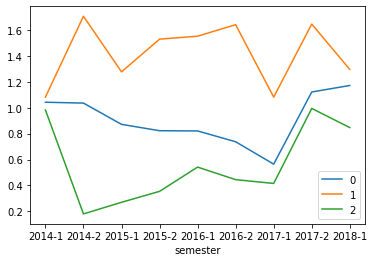

IRPAR_USAGE_V12_MAX


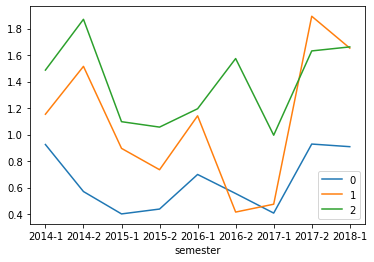

IRPRO_USAGE_V12_MAX


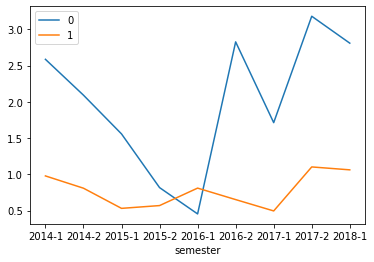

QUA_INT_1_BRP


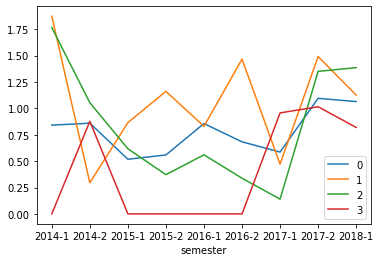

QUA_INT_MAX_BRP


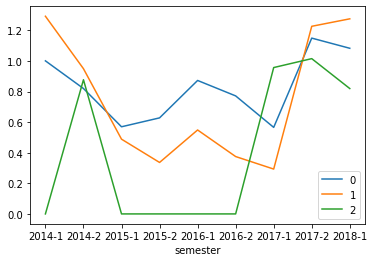

CODTYP_CRT_TRAVAIL_CRI


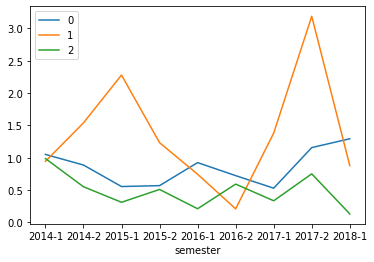

COD_SITU_LOGT_CRI


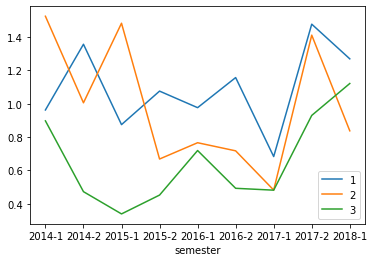

COD_TYPE_MARCHE_CRI


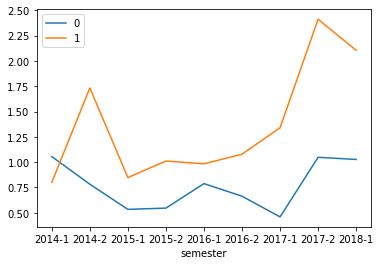

IND_PRIMO_ACCEDT_CRI


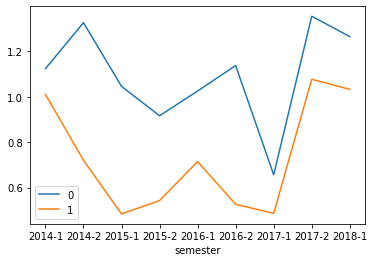

TOP_NAT_FR_CRI


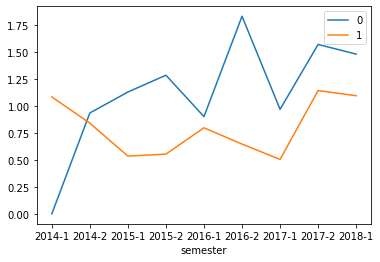

g_MNT_TOT_ASSURANCE_CRI


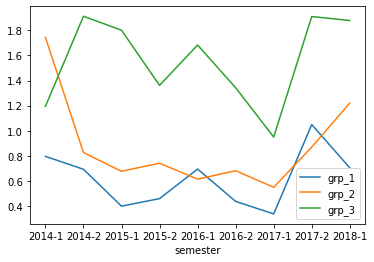

g_COUT_RACHAT_BRP


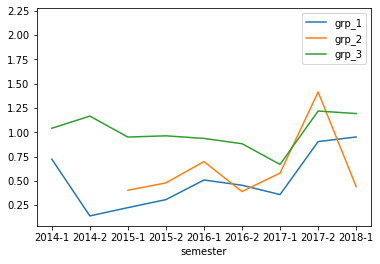

g_quotite


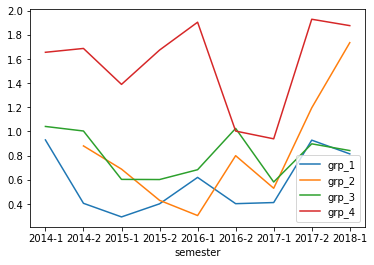

g_PCT_TEG_TAEG_CRI


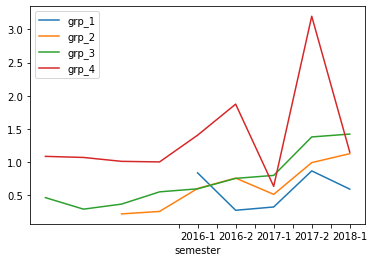

g_MOY_ANC_PROF_BRP


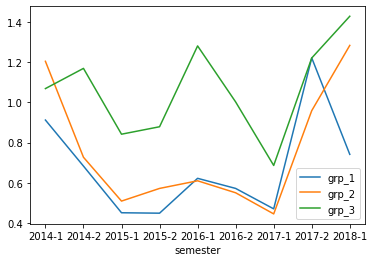

g_BEST_APPORT_TX_BRP


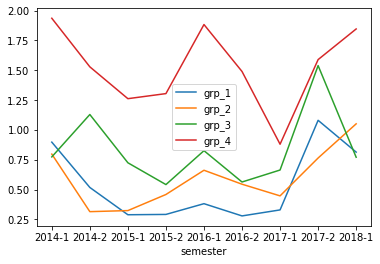

STABILITE DE LA REPARTITION DES MODALITES SELON LE TAUX DE DEFAUT


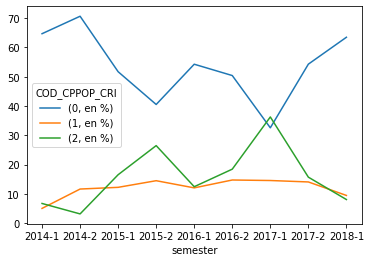

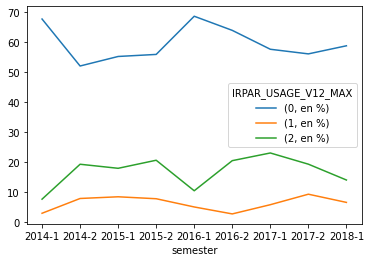

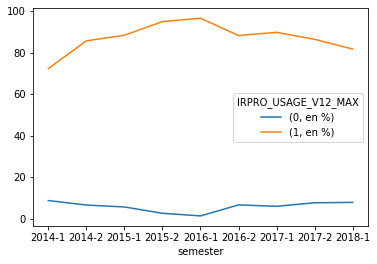

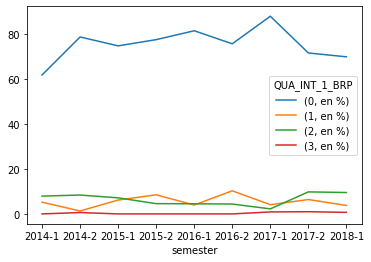

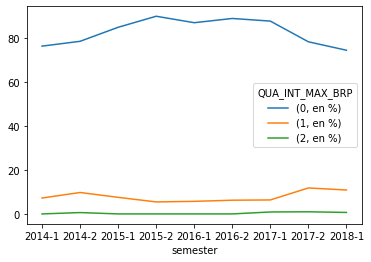

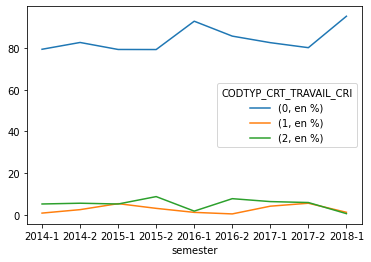

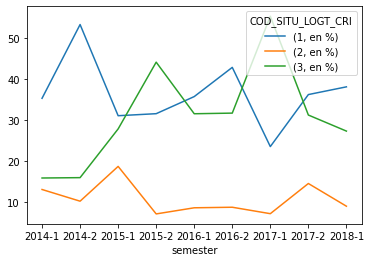

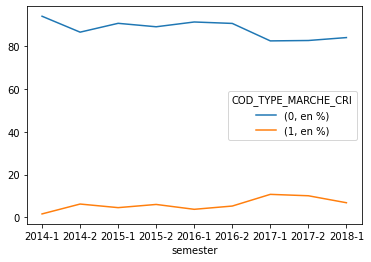

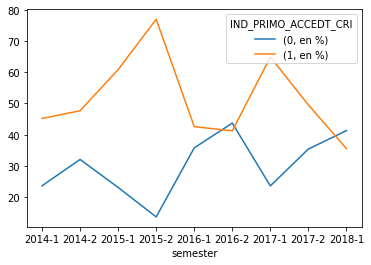

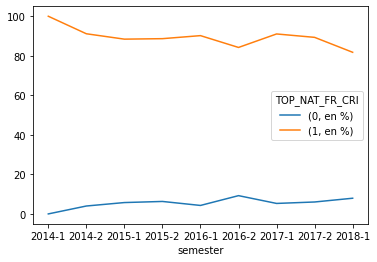

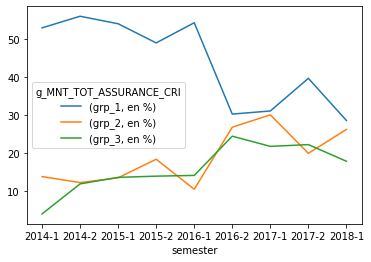

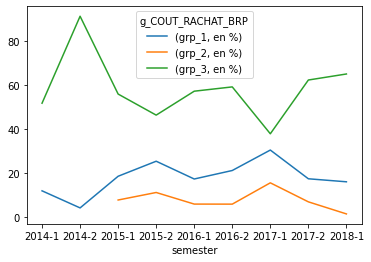

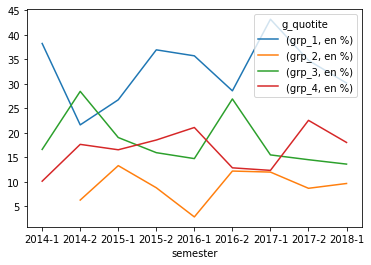

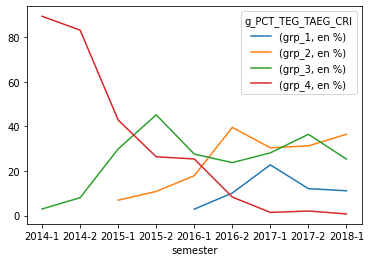

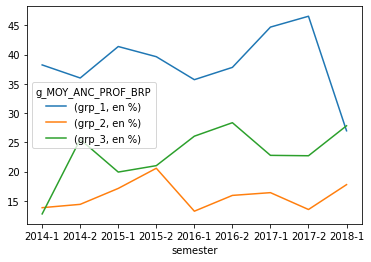

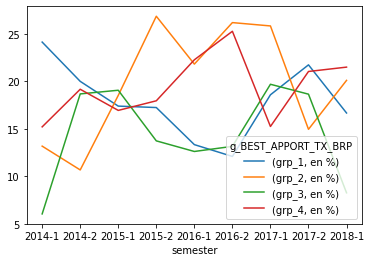

In [203]:
dataviz_stability(stability_data,time_interval='semester',stability_for_modelisation=True)

In [204]:
y_oot_base_clean=oot_base_clean["defaut_36mois"]
x_oot_base=oot_base_clean.drop(columns="defaut_36mois")
y_test_clean=X_test["defaut_36mois"]
x_test=X_test.drop(columns="defaut_36mois")

In [205]:
x_test=pipeline_processing(x_test, y_test_clean,quanti_selected_variables_basename,quali_selected_variables, selected_variables,stability_sample=False, training_option=False )
x_oot_base=pipeline_processing(x_oot_base, y_oot_base_clean,quanti_selected_variables_basename,quali_selected_variables,selected_variables,stability_sample=False, training_option=False )

IMPUTATION PAR 0
OK
IMPUTATION PAR MODE OU MEDIANE
OK
DONE
DONE
Check COD_ETA_BIEN_CRI is selected
DONE
Ces colonnes vont être retirées: ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']
DONE
IMPUTATION PAR 0
OK
IMPUTATION PAR MODE OU MEDIANE
OK
DONE
DONE
Check COD_ETA_BIEN_CRI is selected
DONE
Ces colonnes vont être retirées: ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']
DONE


Vérification pipeline: s'assurer que le nombre de modalités n'augmente pas si nouvelles modalités sur l'échantillon. Vu qu'on crée des dummies cela provoquera la création d'une nouvelle variable..

In [206]:

print(" Vérification de la taille du dataframe pour modélisation...")
print("Nombre de colonnes du dataframe x_train final en one-hot-encodant:",len(pd.get_dummies(X_train_selection[selected_variables],drop_first=True).columns))
print("Nombre de colonnes du dataframe test  en one-hot-encodant:",len(pd.get_dummies(x_test.drop(columns='defaut_36mois'),drop_first=True).columns))
print("Nombre de colonnes du dataframe OOT en one-hot-encodant:",len(pd.get_dummies(x_oot_base.drop(columns='defaut_36mois'),drop_first=True).columns))




 Vérification de la taille du dataframe pour modélisation...
Nombre de colonnes du dataframe x_train final en one-hot-encodant: 32
Nombre de colonnes du dataframe test  en one-hot-encodant: 32
Nombre de colonnes du dataframe OOT en one-hot-encodant: 32


In [207]:
x_oot_base.to_csv('x_oot.csv')
x_test.to_csv('x_test.csv')
X_train_selection.to_csv('x_train.csv')